<a href="https://colab.research.google.com/github/Hassanmoin3/Segmentation-and-counting-of-teeths-using-panoramic-dental-X-rays/blob/main/Script/256x256_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Libraries**

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 34.0 MB/s eta 0:00:00


# **Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **GPU Check**

In [ ]:
!nvidia-smi

Wed Aug  9 00:41:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Appending Path on Drive**

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/dissertation/")

In [ ]:

%cd /content/drive/MyDrive/dissertation

/content/drive/MyDrive/dissertation


# **Loading and Preparing Images**

In [ ]:
from images_prepare import *
path = "/content/drive/MyDrive/dissertation/Data"
X,X_sizes=pre_images((256,256),path,True)
len(X)

1000

# **Loading and Preparing Masks**

In [ ]:
from masks_prepare import *
Y=pre_masks(resize_shape=(256,256),path='/content/drive/MyDrive/dissertation/Data/Original_Masks1')
len(Y)

1000

In [ ]:
X=np.float32(X/255)
Y=np.float32(Y/255)
print(len(X))
print(len(Y))

1000
1000


# **Splitting Image and Masks**

In [ ]:
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(X, Y , test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=42)

# **Exploratory Data Analysis**

## **Display Random Images**

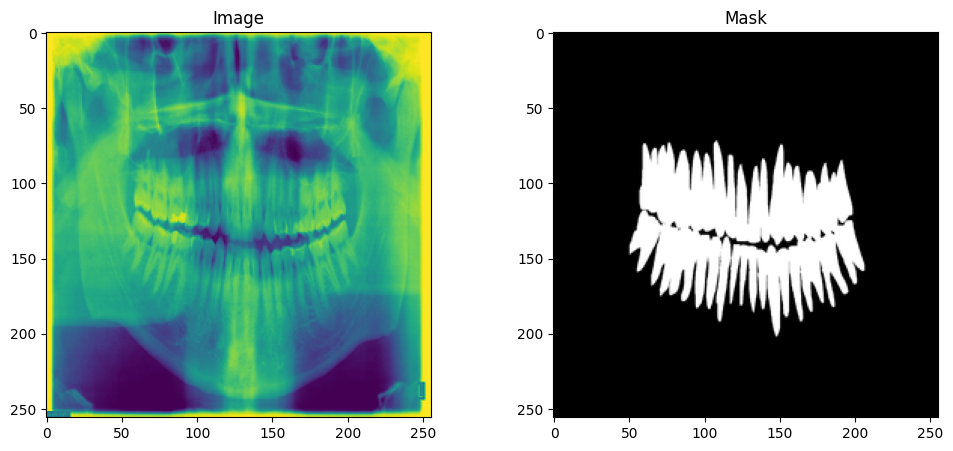

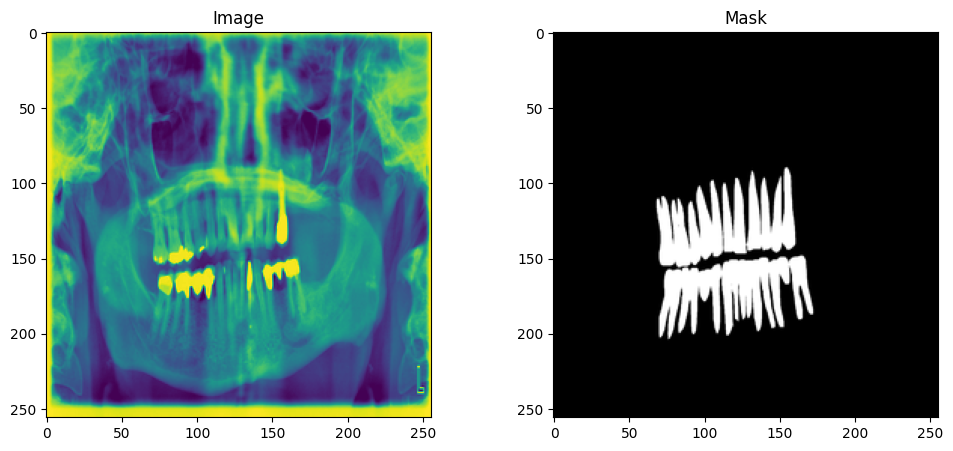

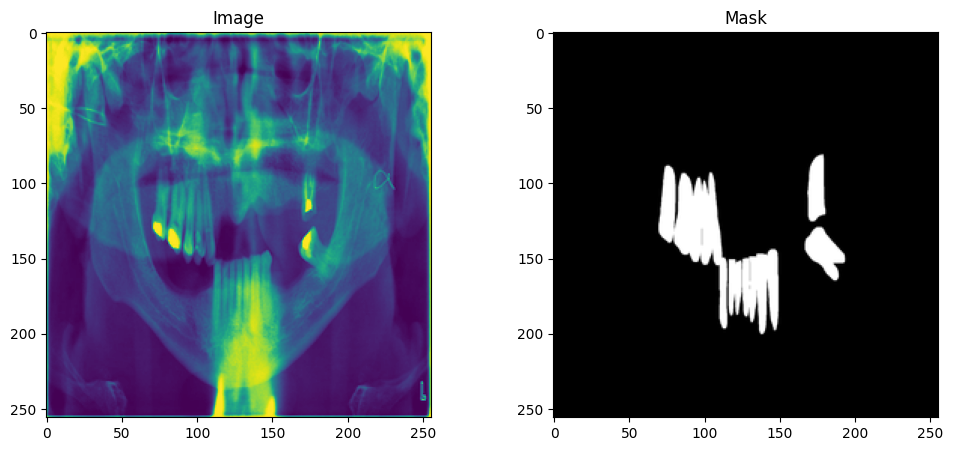

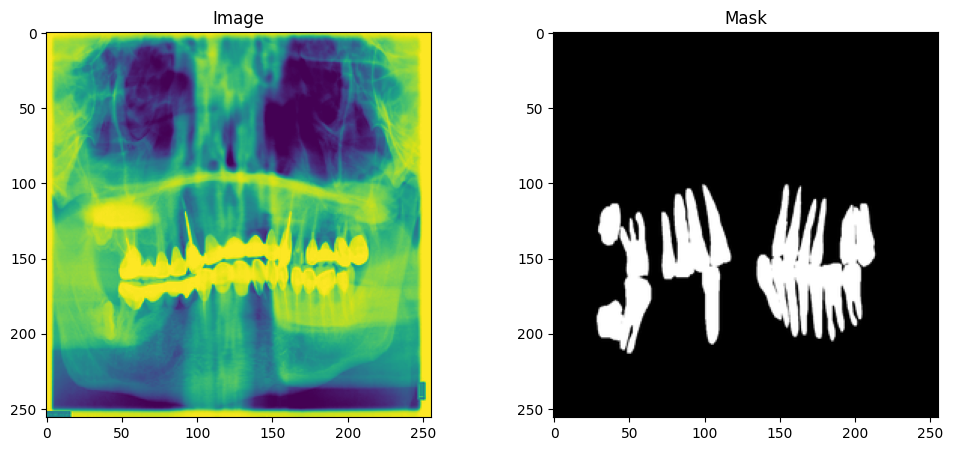

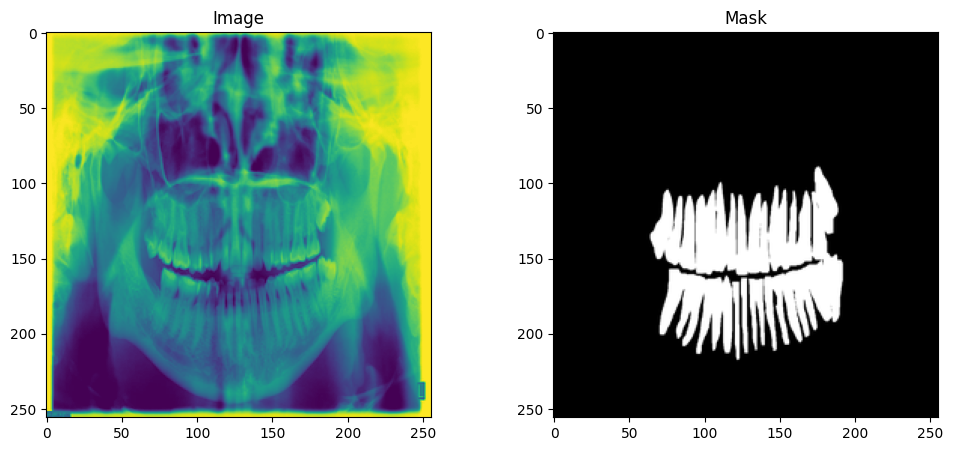

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_random_images(x, y, num=5):
    idx = np.random.choice(len(x), size=num, replace=False)

    for i in idx:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(x[i])
        plt.title("Image")

        plt.subplot(1, 2, 2)
        plt.imshow(y[i], cmap='gray')
        plt.title("Mask")

        plt.show()

display_random_images(x_train, y_train)

## **Distribution of Images**

In [ ]:
print(f"Training data: {len(x_train)} images")
print(f"Validation data: {len(x_val)} images")
print(f"Test data: {len(x_test)} images")

Training data: 600 images
Validation data: 200 images
Test data: 200 images


## **Image Statistics**

In [ ]:
train_pixel_values = np.array([np.mean(img) for img in x_train])
print(f"Mean pixel value in training images: {np.mean(train_pixel_values)}")
print(f"Std pixel value in training images: {np.std(train_pixel_values)}")

Mean pixel value in training images: 0.4749009311199188
Std pixel value in training images: 0.09164129197597504


## **Check for Missing Data**

In [ ]:
print(f"Missing training images: {np.sum(np.isnan(x_train))}")
print(f"Missing training masks: {np.sum(np.isnan(y_train))}")

Missing training images: 0
Missing training masks: 0


## **Histogram of Pixel Values**

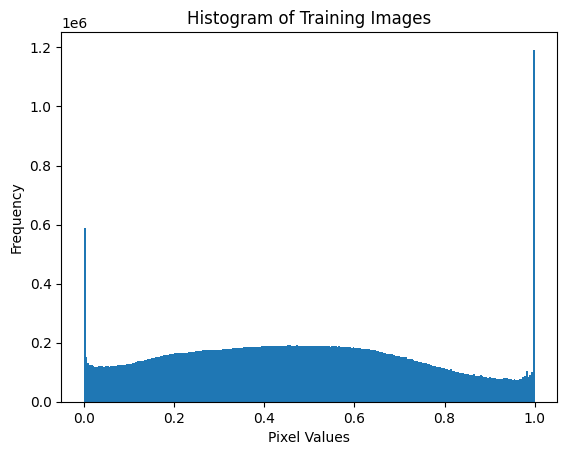

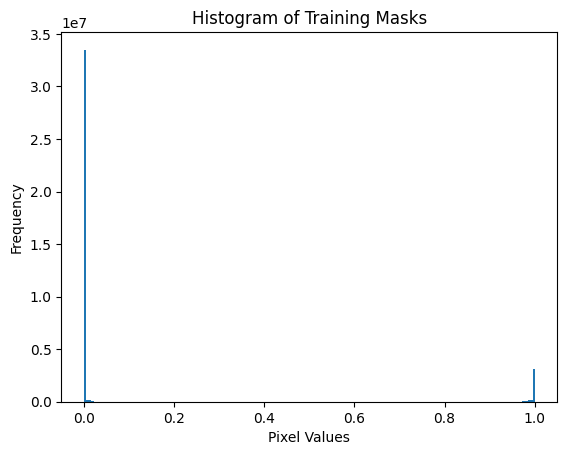

In [ ]:
def plot_histogram(images, title):
    plt.hist(images.ravel(), bins=255)
    plt.xlabel('Pixel Values')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

plot_histogram(x_train, 'Histogram of Training Images')
plot_histogram(y_train, 'Histogram of Training Masks')

## **Unique Classes in Masks**

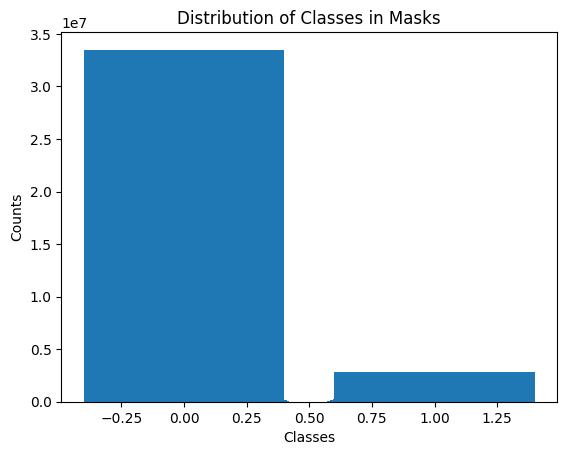

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribution of Classes in Masks')
plt.show()

# **Applying augmentation to the Data**

In [ ]:
import cv2

import albumentations as A

aug = A.Compose([
    A.OneOf([A.RandomCrop(width=256, height=256),

                 A.PadIfNeeded(min_height=256, min_width=256, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(256, 256, border_mode=cv2.BORDER_CONSTANT),
                            A.Resize(256, 256, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)
count=0
while(count<4):
  x_aug2=np.copy(x_train1)
  y_aug2=np.copy(y_train1)
  for i in range(len(x_train1)):
    augmented=aug(image=x_train1[i,:,:,:],mask=y_train1[i,:,:,:])
    x_aug2[i,:,:,:]= augmented['image']
    y_aug2[i,:,:,:]= augmented['mask']
  x_train=np.concatenate((x_train,x_aug2))
  y_train=np.concatenate((y_train,y_aug2))
  if count == 9:
    break
  count += 1

In [ ]:
del x_aug2
del X
del Y
del y_aug2
del y_train1
del x_train1
del augmented

In [ ]:
print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))

3000
200
3000
200


# **Image and Mask check before Training**

In [ ]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)
print(random_number)

104


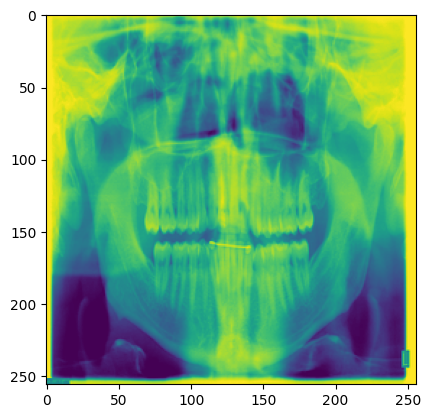

In [ ]:
plt.imshow(x_train[random_number,:,:,0])

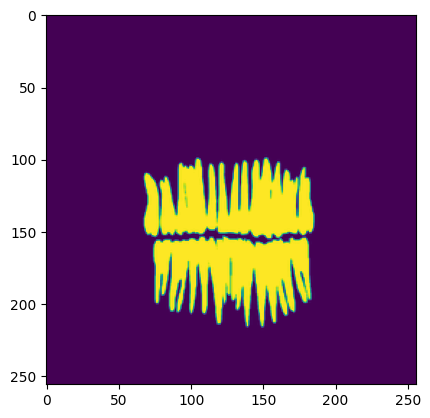

In [ ]:
plt.imshow(y_train[random_number,:,:,0])

# **Training**

### **Definition for visualization of results**

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(test_image, true_mask, predicted_mask):
    plt.figure(figsize=(18, 6))

    # Displaying the test image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    # Displaying the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Segmentation Mask')
    plt.axis('off')

    # Displaying the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def detailed_visualization(test_image, true_mask, predicted_mask):
    plt.figure(figsize=(20, 10))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    # True Mask
    plt.subplot(2, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Segmentation Mask')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(2, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')

    # Overlay of Predicted on Image
    overlay = np.stack([test_image]*3, axis=-1)
    where_mask = np.where(predicted_mask > 0.5)
    overlay[where_mask[0], where_mask[1], :] = [255, 0, 0]
    plt.subplot(2, 3, 4)
    plt.imshow(overlay)
    plt.title('Overlay of Predicted on Image')
    plt.axis('off')

    # Difference between Predicted and True
    difference = np.abs(predicted_mask - true_mask)
    plt.subplot(2, 3, 5)
    plt.imshow(difference, cmap='jet')  # Using a different colormap to highlight differences
    plt.title('Difference between True and Predicted')
    plt.axis('off')

    # Histogram of Predicted Values
    plt.subplot(2, 3, 6)
    plt.hist(predicted_mask.ravel(), bins=50)
    plt.title('Histogram of Predicted Values')

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def advanced_visualization(test_image, true_mask, predicted_mask, threshold=0.5):
    # Binary conversion of predicted_mask
    binary_predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Normalize test_image to [0, 1] if it's float
    if test_image.dtype == np.float32 or test_image.dtype == np.float64:
        test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())

    # Errors
    false_positives = np.where((binary_predicted_mask == 1) & (true_mask == 0))
    false_negatives = np.where((binary_predicted_mask == 0) & (true_mask == 1))

    plt.figure(figsize=(20, 10))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    # True vs Predicted Masks
    overlay = np.stack([test_image]*3, axis=-1)
    overlay[false_positives[0], false_positives[1], :] = [1, 0, 0]
    overlay[false_negatives[0], false_negatives[1], :] = [0, 0, 1]
    plt.subplot(2, 3, 2)
    plt.imshow(overlay)
    plt.title('Errors Highlighted (FP=Red, FN=Blue)')
    plt.axis('off')

    # Zoomed Region
    # (Modify these to focus on a specific region of interest)
    zoom_region = (slice(100, 200), slice(100, 200))
    plt.subplot(2, 3, 3)
    plt.imshow(test_image[zoom_region], cmap='gray')
    plt.title('Zoomed Region of Test Image')
    plt.axis('off')

    # Confusion Matrix
    cm = confusion_matrix(true_mask.astype(np.uint8).flatten(), binary_predicted_mask.flatten())
    plt.subplot(2, 3, 4)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

### **UNET Model**

In [ ]:
from model import *
model=UNET(input_shape=(256,256,1),last_activation='sigmoid')
model.summary()
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x_train,y_train,batch_size=8,epochs=200,verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

### **Save Model**

In [ ]:
import tensorflow as tf
tf.keras.models.save_model(model, '/content/drive/MyDrive/dissertation/models/dental_xray_seg_new_data_1000_imges.h5')

### **Load the model if model is already on Drive**

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/dissertation/models/dental_xray_seg_new_data_1000_imges.h5')

### **UNET Model Prediction**

In [ ]:
predict_img_unet=model.predict(x_test)
predict=predict_img_unet[1,:,:,0]

7/7 [==============================] - 2s 270ms/step


### **F1-SCORE UNET Model**

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
predict_img1_unet=(predict_img_unet>0.25)*1
y_test1=(y_test>0.25)*1
f1_score(predict_img1_unet.flatten(), y_test1.flatten(), average='micro')

0.9789090728759766

### **Accuracy Test UNET Model**

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Threshold the predictions and ground truth
predict_img1_unet = (predict_img_unet > 0.25) * 1
y_test1 = (y_test > 0.25) * 1
accuracy = accuracy_score(y_test1.flatten(), predict_img1_unet.flatten())
print(f'Accuracy: {accuracy}')


Accuracy: 0.9789090728759766


### **Dice score**

In [ ]:
# Calculate Dice score
dice_score = (2 * np.sum(predict_img1_unet * y_test1)) / (np.sum(predict_img1_unet) + np.sum(y_test1))
print("Dice Score:", dice_score)

Dice Score: 0.9189958809776297


### **Precision, Recell, Jaccard Score, IoU**

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, jaccard_score

y_test_flat = y_test1.flatten()
predict_flat = predict_img1_unet.flatten()

threshold = 0.5
predict_binary = np.where(predict_flat > threshold, 1, 0)

precision = precision_score(y_test_flat, predict_binary)
recall = recall_score(y_test_flat, predict_binary)
jaccard_coefficient = jaccard_score(y_test_flat, predict_binary)

intersection = np.sum(y_test_flat & predict_binary)
union = np.sum(y_test_flat | predict_binary)
iou = intersection / union

print("Precision:", precision)
print("Recall:", recall)
print("Jaccard Coefficient (IoU):", jaccard_coefficient)
print("IoU:", iou)

Precision: 0.9026403495138925
Recall: 0.9359550635567044
Jaccard Coefficient (IoU): 0.850131710699441
IoU: 0.850131710699441


### **Visualizing the Results of UNET Model**

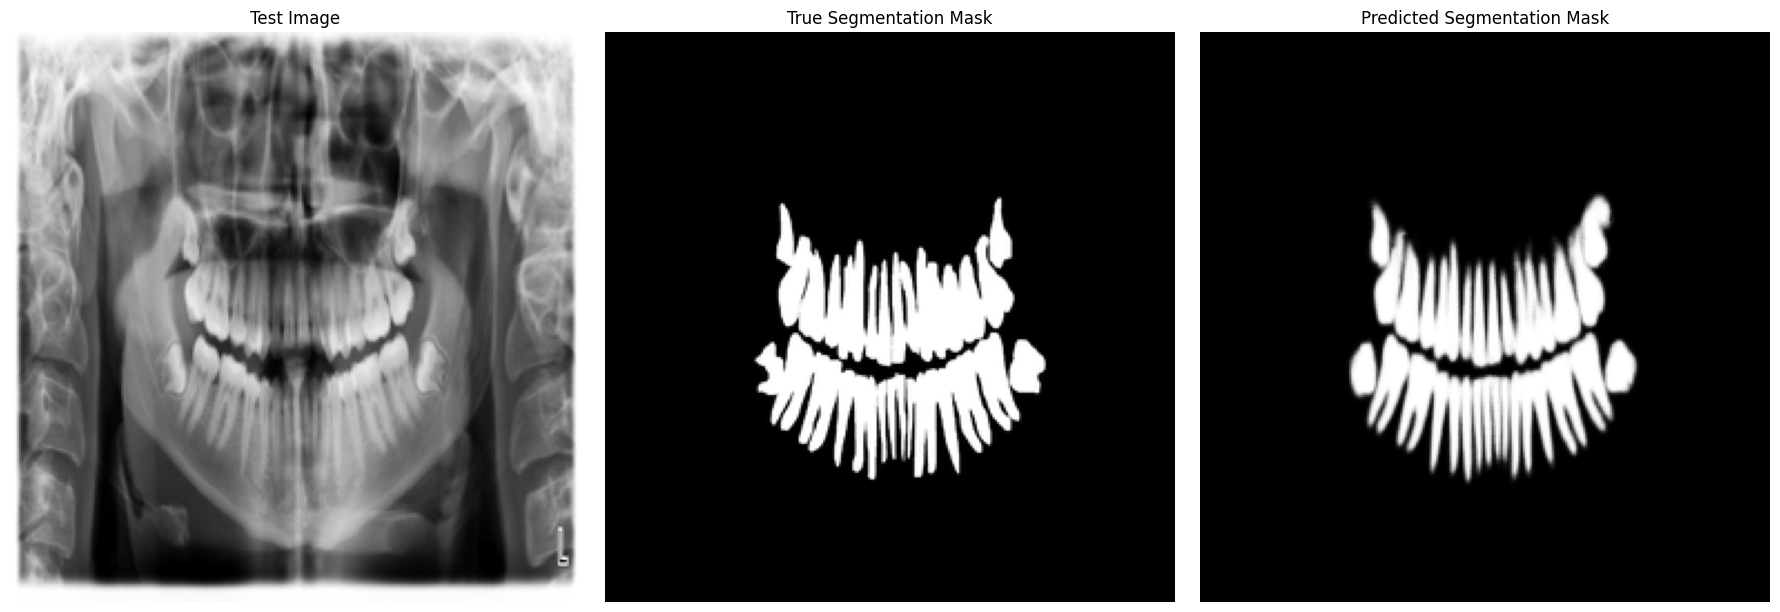

In [ ]:
visualize_prediction(x_test[1,:,:,0], y_test[1,:,:,0], predict)

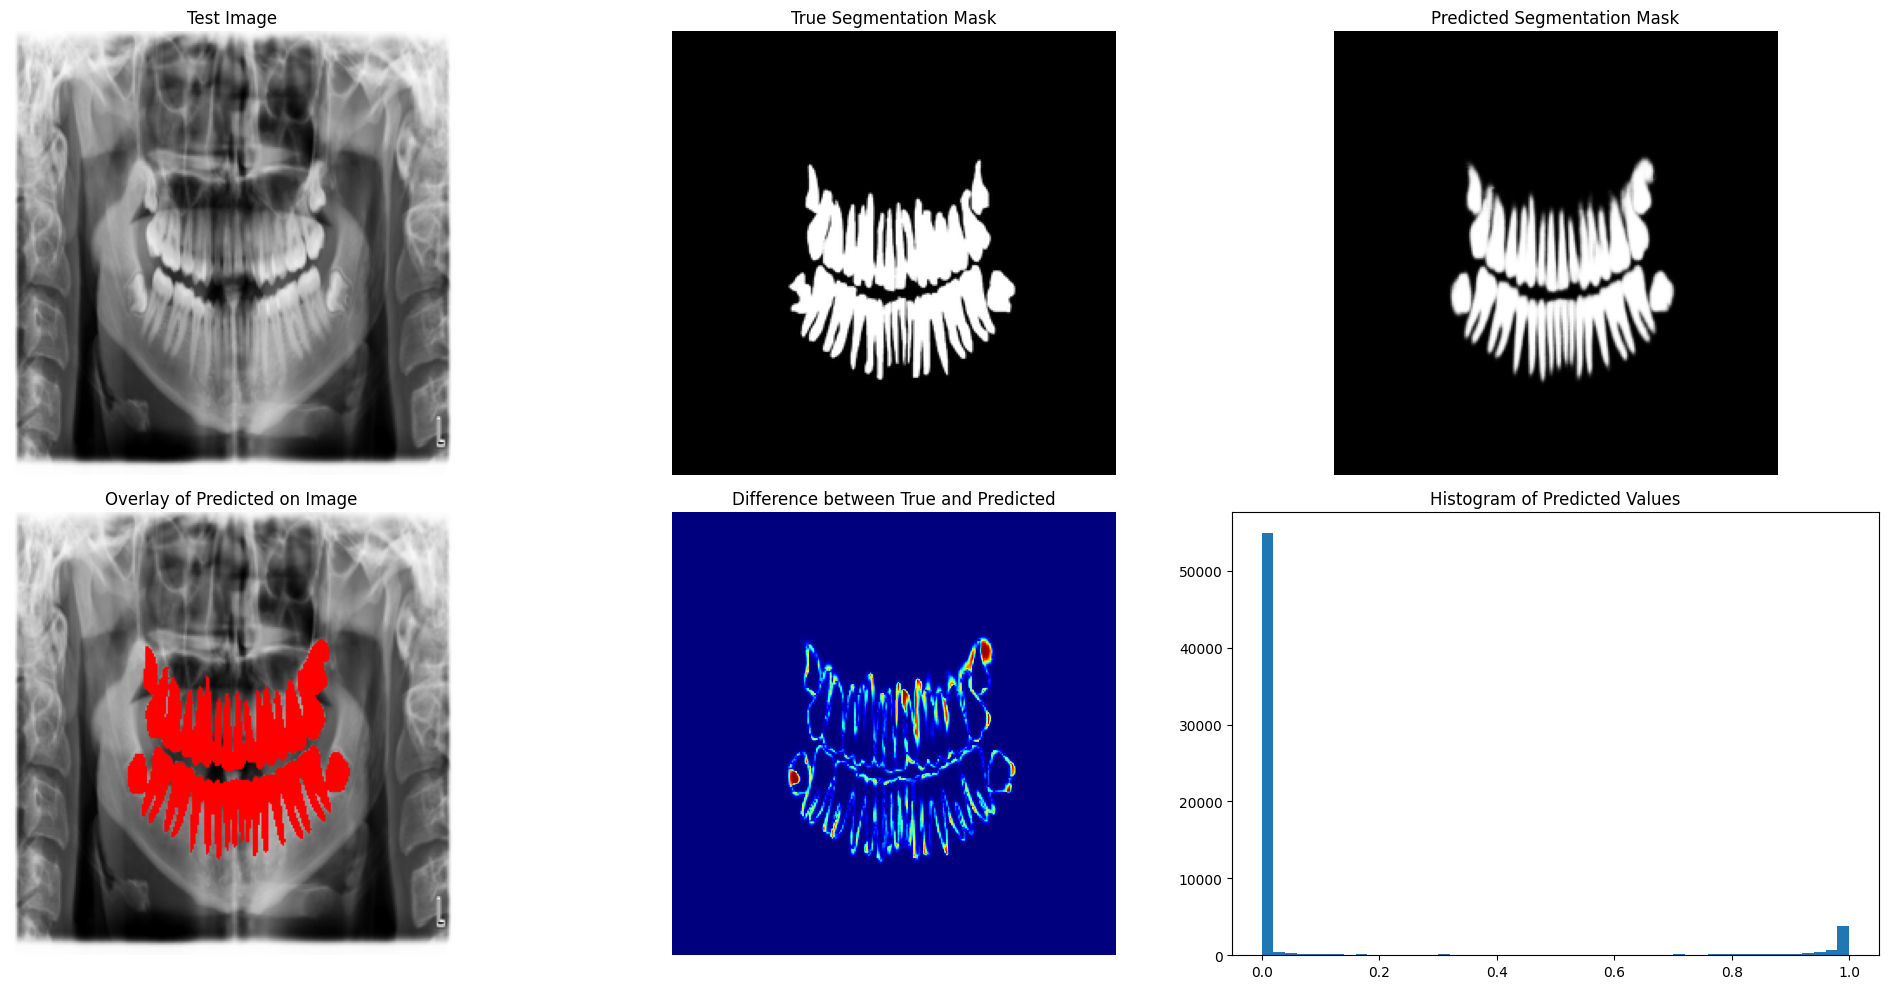

In [ ]:
detailed_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

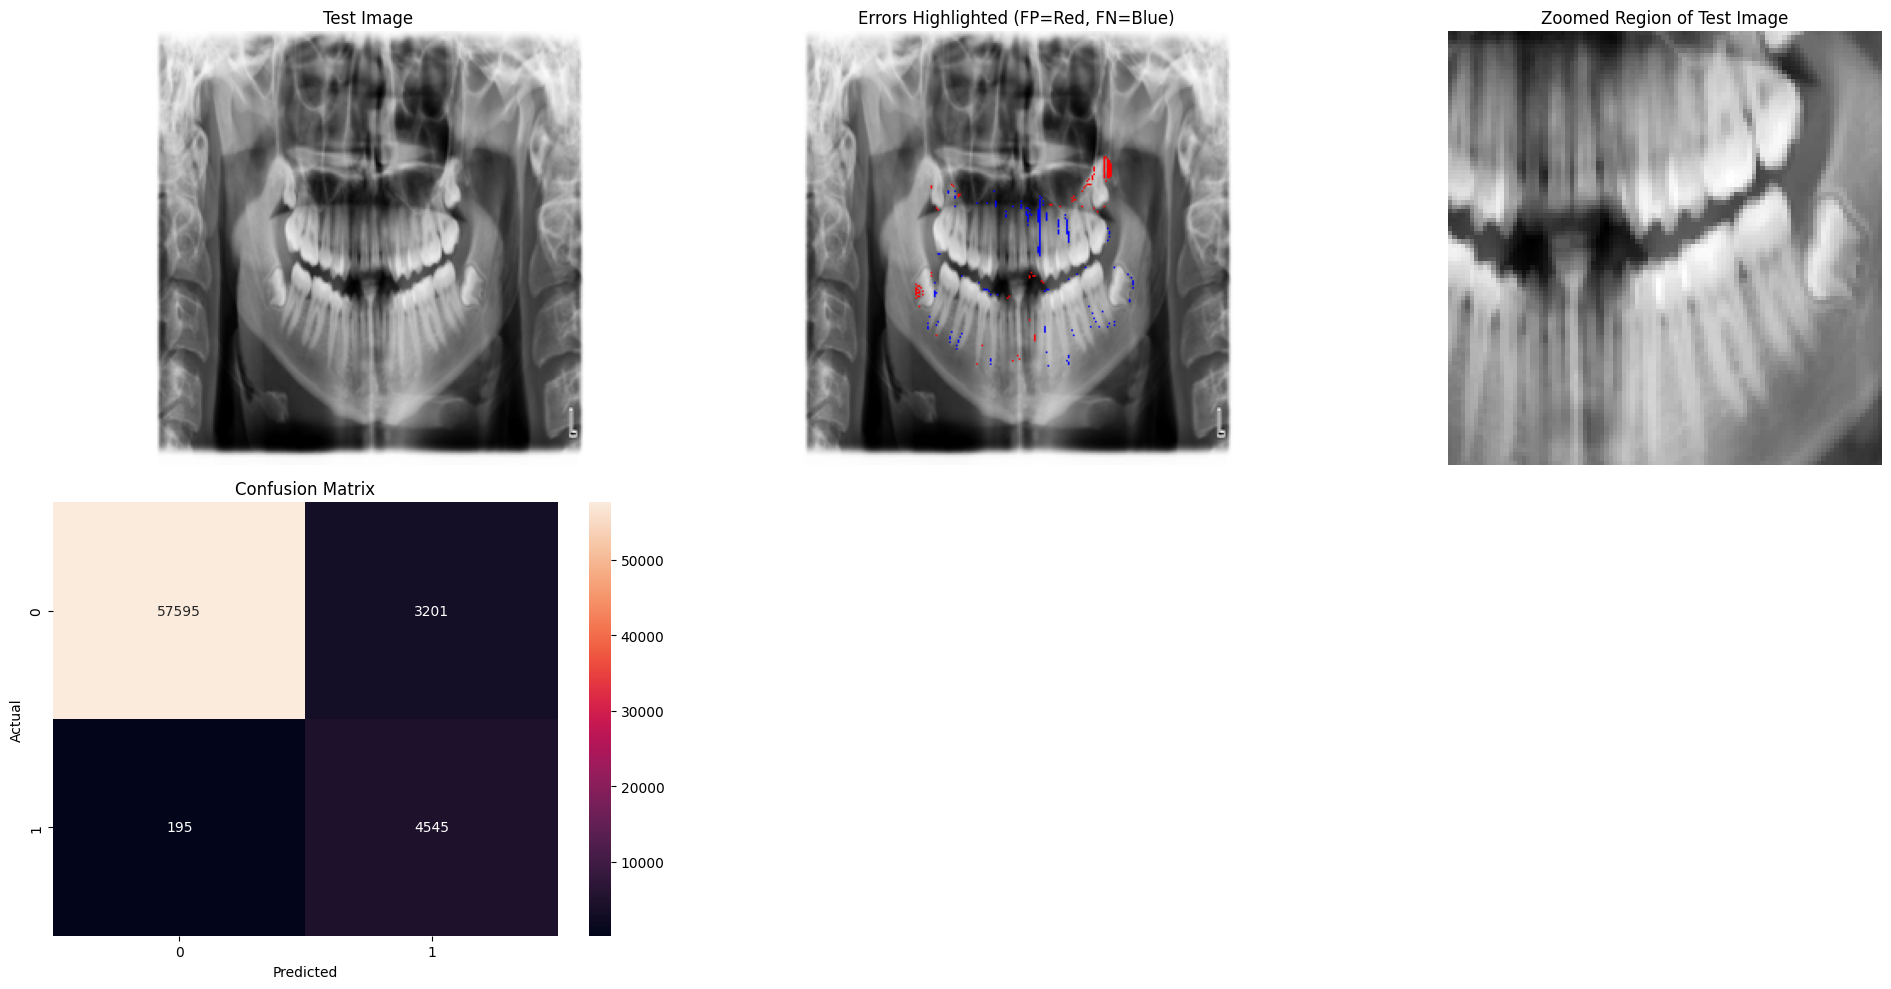

In [ ]:
advanced_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

### **Feedback Unet Model**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation

def feedback_unet(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    up1 = UpSampling2D(size=(2, 2))(pool2)
    up1 = Conv2D(64, 2, padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    merge1 = Concatenate(axis=3)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(merge1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = UpSampling2D(size=(2, 2))(conv3)
    up2 = Conv2D(32, 2, padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    merge2 = Concatenate(axis=3)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(merge2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    output = Conv2D(1, 1, activation='sigmoid')(conv4)

    model = Model(inputs=inputs, outputs=output)
    return model

input_shape = (256, 256, 1)
funet_model = feedback_unet(input_shape)
funet_model.summary()

funet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

funet_model.fit(x_train, y_train, batch_size=8, epochs=200, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 256, 256, 64  256        ['conv2d_11[0][0]']              
 ormalization)                  )                                                           

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Dropout, LeakyReLU
from keras.optimizers import Adam

def feedback_unet(input_shape):
    dropout_rate = 0.5

    # Encoder
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder with feedback connections
    up1 = UpSampling2D(size=(2, 2))(pool2)
    up1 = Conv2D(64, 2, padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = LeakyReLU()(up1)
    merge1 = Concatenate(axis=3)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(merge1)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU()(conv3)
    conv3 = Dropout(dropout_rate)(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU()(conv3)

    up2 = UpSampling2D(size=(2, 2))(conv3)
    up2 = Conv2D(32, 2, padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = LeakyReLU()(up2)
    merge2 = Concatenate(axis=3)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(merge2)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU()(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU()(conv4)

    # Output
    output = Conv2D(1, 1, activation='sigmoid')(conv4)

    model = Model(inputs=inputs, outputs=output)
    return model

# Usage example
input_shape = (256, 256, 1)  # Example input shape
funet_model = feedback_unet(input_shape)
funet_model.summary()

funet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

funet_model.fit(x_train, y_train, batch_size=16, epochs=200, verbose=1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

### **Save Model**

In [ ]:
import tensorflow as tf
tf.keras.models.save_model(funet_model, '/content/drive/MyDrive/dissertation/models/dental_xray_seg_funet_new_data_1000_images.h5')

### **Load the model if already on Drive**

In [ ]:
from tensorflow import keras
funet_model = keras.models.load_model('/content/drive/MyDrive/dissertation/models/dental_xray_seg_funet_new_data_1000_images.h5')

###**Feedback Unet Model Prediction**

In [ ]:
predict_img_funet=funet_model.predict(x_test)
predict=predict_img_funet[1,:,:,0]

7/7 [==============================] - 14s 776ms/step


### **F1-Score**

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
predict_img1_funet=(predict_img_funet>0.25)*1
y_test1=(y_test>0.25)*1
f1_score(predict_img1_funet.flatten(), y_test1.flatten(), average='micro')

0.9665442657470702

### **Dice Score**

In [ ]:
dice_score = (2 * np.sum(predict_img1_funet * y_test1)) / (np.sum(predict_img1_funet) + np.sum(y_test1))
print("Dice Score:", dice_score)

Dice Score: 0.8765010658380664


### **Precison, Recall, Jaccard Score, IoU**

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, jaccard_score

y_test_flat = y_test1.flatten()
predict_flat = predict_img1_funet.flatten()

threshold = 0.5
predict_binary = np.where(predict_flat > threshold, 1, 0)

precision = precision_score(y_test_flat, predict_binary)
recall = recall_score(y_test_flat, predict_binary)
jaccard_coefficient = jaccard_score(y_test_flat, predict_binary)

intersection = np.sum(y_test_flat & predict_binary)
union = np.sum(y_test_flat | predict_binary)
iou = intersection / union

print("Precision:", precision)
print("Recall:", recall)
print("Jaccard Coefficient (IoU):", jaccard_coefficient)
print("IoU:", iou)

Precision: 0.8297941549431715
Recall: 0.928779605033445
Jaccard Coefficient (IoU): 0.7801530016509418
IoU: 0.7801530016509418


### **Visualizing the Results of Feedback Unet Model**



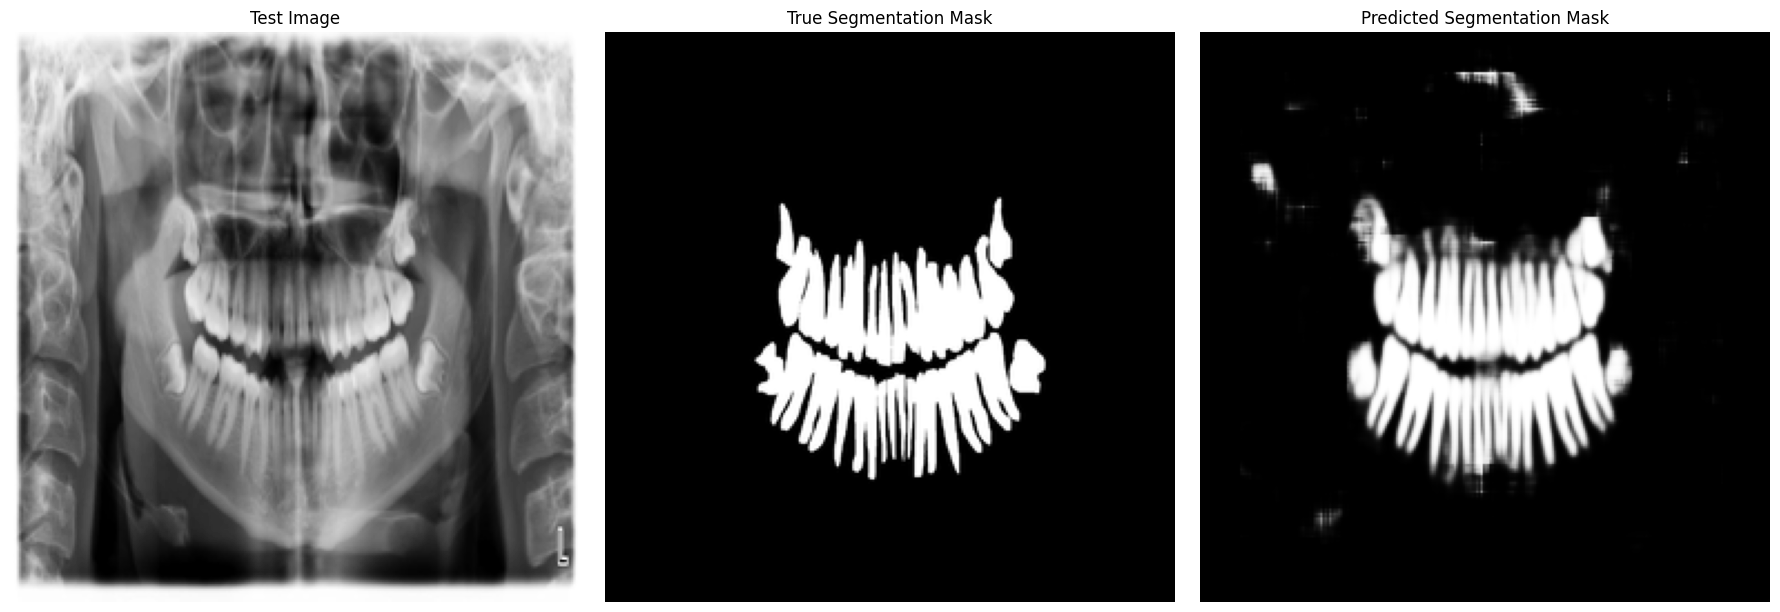

In [ ]:
visualize_prediction(x_test[1,:,:,0], y_test[1,:,:,0], predict)

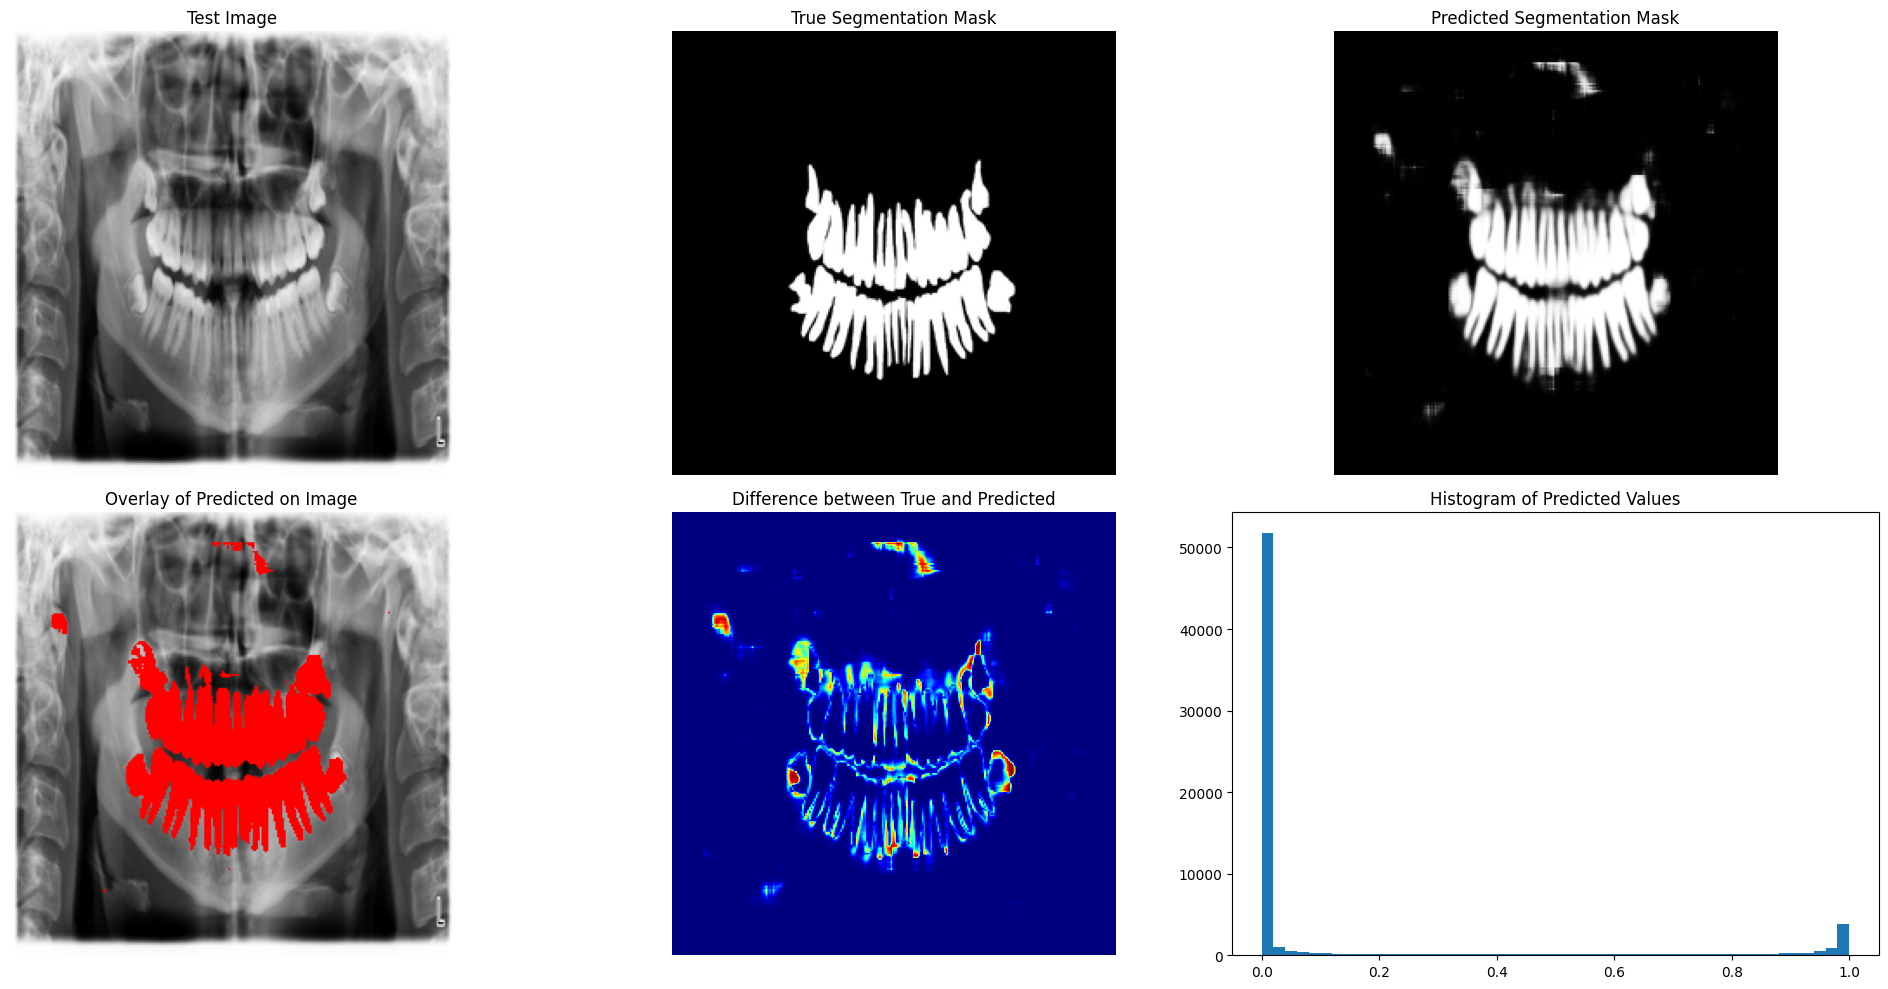

In [ ]:
detailed_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

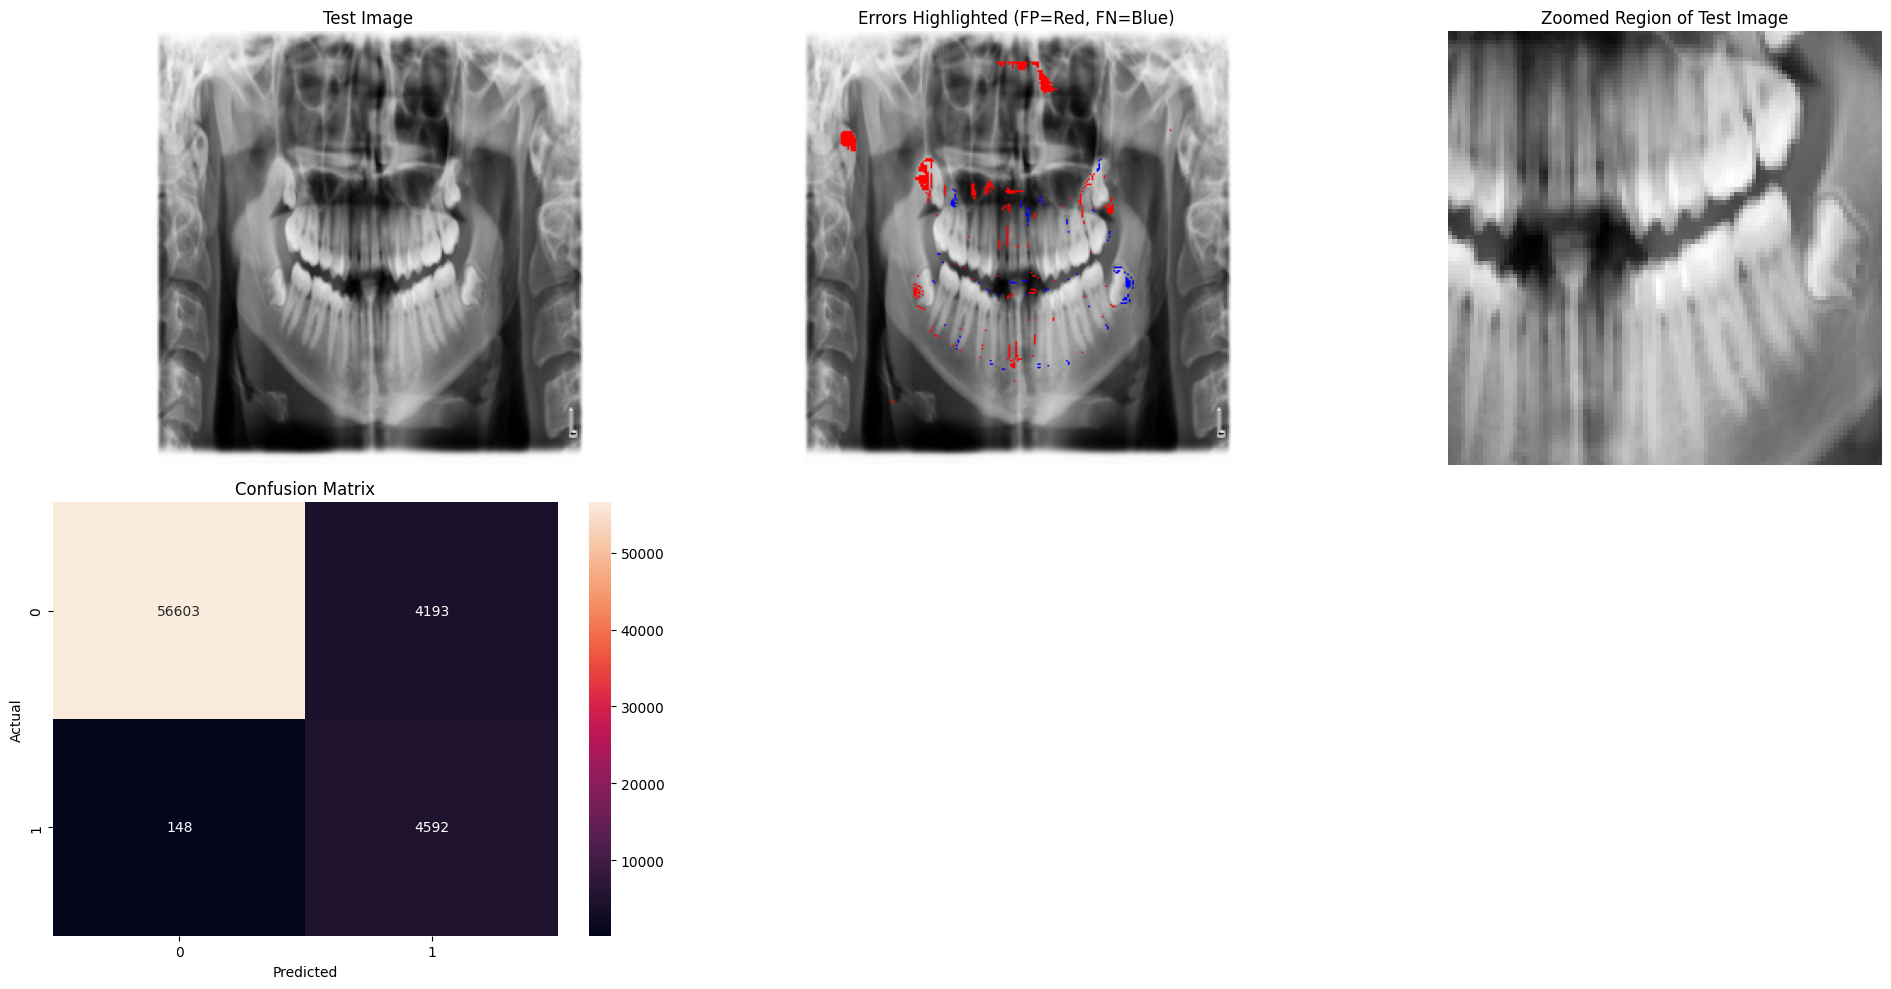

In [ ]:
advanced_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

### **Feedback Unet Model with ConvLSTM2D**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from keras.layers import ConvLSTM2D, Conv3D, Lambda, Subtract, Reshape

def feedback_unet(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    up1 = UpSampling2D(size=(2, 2))(pool2)
    up1 = Conv2D(64, 2, padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    merge1 = Concatenate(axis=3)([conv2, up1])

    convlstm1 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(Reshape((1, *merge1.shape[1:]))(merge1))
    convlstm1 = BatchNormalization()(convlstm1)
    convlstm1 = Activation('relu')(convlstm1)
    convlstm1 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same')(convlstm1)
    convlstm1 = BatchNormalization()(convlstm1)
    convlstm1 = Activation('relu')(convlstm1)

    conv3 = Conv2D(128, 3, padding='same')(convlstm1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = UpSampling2D(size=(2, 2))(conv3)
    up2 = Conv2D(32, 2, padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    merge2 = Concatenate(axis=3)([conv1, up2])

    convlstm2 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True)(Reshape((1, *merge2.shape[1:]))(merge2))
    convlstm2 = BatchNormalization()(convlstm2)
    convlstm2 = Activation('relu')(convlstm2)
    convlstm2 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same')(convlstm2)
    convlstm2 = BatchNormalization()(convlstm2)
    convlstm2 = Activation('relu')(convlstm2)

    conv4 = Conv2D(64, 3, padding='same')(convlstm2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    output = Conv2D(1, 1, activation='sigmoid')(conv4)

    output_prev = output
    convlstm3 = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', return_sequences=True)(Reshape((1, *output_prev.shape[1:]))(output_prev))
    convlstm3 = BatchNormalization()(convlstm3)
    convlstm3 = Activation('relu')(convlstm3)
    convlstm3 = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same')(convlstm3)
    convlstm3 = BatchNormalization()(convlstm3)
    convlstm3 = Activation('relu')(convlstm3)
    output = Subtract()([output_prev, convlstm3])

    model = Model(inputs=inputs, outputs=output)
    return model

input_shape = (256, 256, 1)
funet_model = feedback_unet(input_shape)
funet_model.summary()

funet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
funet_model.fit(x_train, y_train, batch_size=8, epochs=100, verbose=1)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_13[0][0]']              
 ormalization)                  )                                                           

### **Save Model**

In [ ]:
import tensorflow as tf
tf.keras.models.save_model(funet_model, '/content/drive/MyDrive/dissertation/models/dental_xray_seg_funet_v3_new_data_1000_images_convlstm1.h5')

### **Load the model if already on Drive**

In [ ]:
from tensorflow import keras
funet_model_v2 = keras.models.load_model('/content/drive/MyDrive/dissertation/models/dental_xray_seg_funet_v3_new_data_1000_images_convlstm1.h5')

### **Feedback Unet Model with ConvLSTM2D Prediction**

In [ ]:
predict_img_funet_v2=funet_model_v2.predict(x_test)
predict=predict_img_funet_v2[1,:,:,0]

7/7 [==============================] - 13s 1s/step


### **F1-Score**

In [ ]:
#Example Test F-UNET
from sklearn.metrics import f1_score
import numpy as np
predict_img1_funet_v2=(predict_img_funet_v2>0.25)*1
y_test1=(y_test>0.25)*1
f1_score(predict_img1_funet_v2.flatten(), y_test1.flatten(), average='micro')

0.9726367950439453

### **Dice Score**

In [ ]:
dice_score = (2 * np.sum(predict_img1_funet_v2 * y_test1)) / (np.sum(predict_img1_funet_v2) + np.sum(y_test1))
print("Dice Score:", dice_score)

Dice Score: 0.8983522611169731


### **Precison, Recall, Jaccard Score, IoU**

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, jaccard_score
y_test_flat = y_test1.flatten()
predict_flat = predict_img1_funet_v2.flatten()
threshold = 0.5
predict_binary = np.where(predict_flat > threshold, 1, 0)

precision = precision_score(y_test_flat, predict_binary)
recall = recall_score(y_test_flat, predict_binary)
jaccard_coefficient = jaccard_score(y_test_flat, predict_binary)

intersection = np.sum(y_test_flat & predict_binary)
union = np.sum(y_test_flat | predict_binary)
iou = intersection / union

print("Precision:", precision)
print("Recall:", recall)
print("Jaccard Coefficient (IoU):", jaccard_coefficient)
print("IoU:", iou)

Precision: 0.8553139864585548
Recall: 0.9459512854289011
Jaccard Coefficient (IoU): 0.8154623564405646
IoU: 0.8154623564405646


### **Visualizing the Results of Feedback Unet Model with ConvLSTM2D**

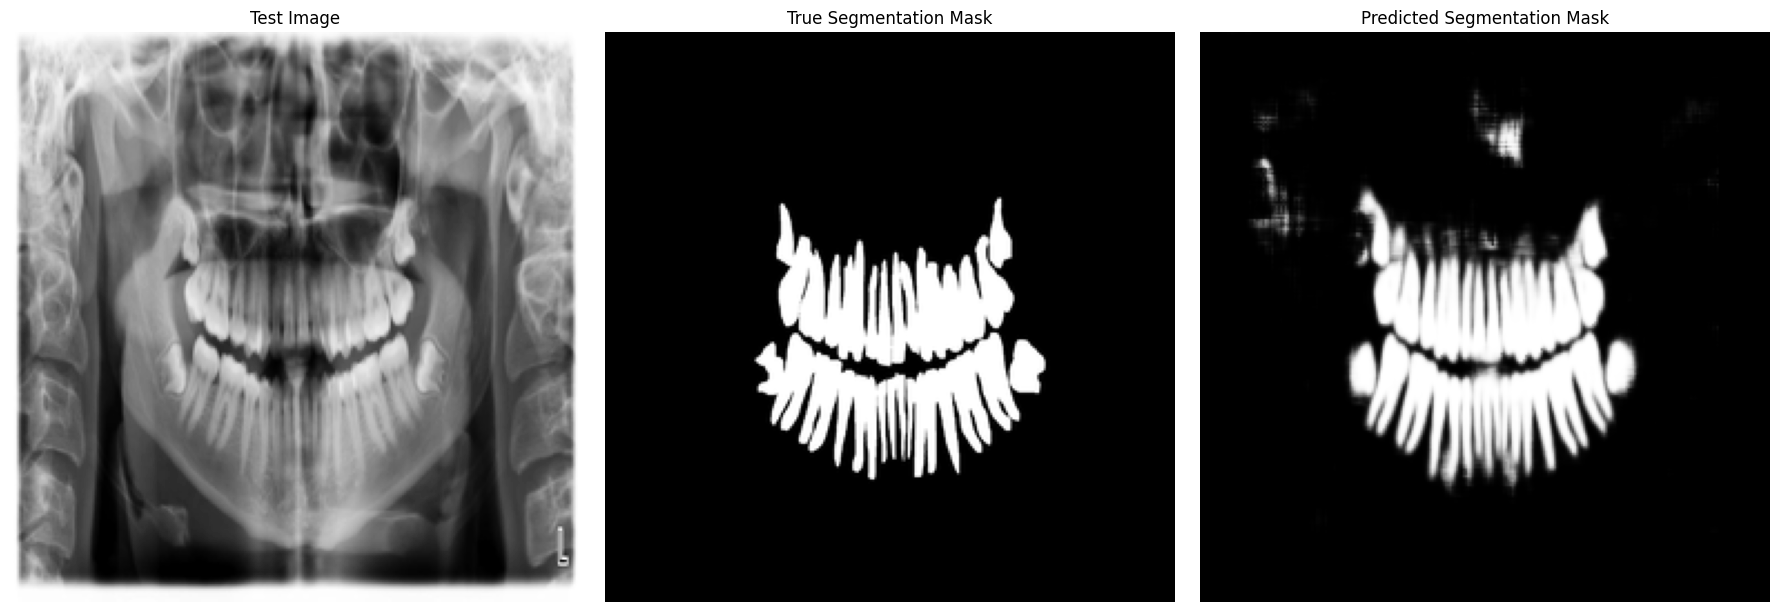

In [ ]:
visualize_prediction(x_test[1,:,:,0], y_test[1,:,:,0], predict)

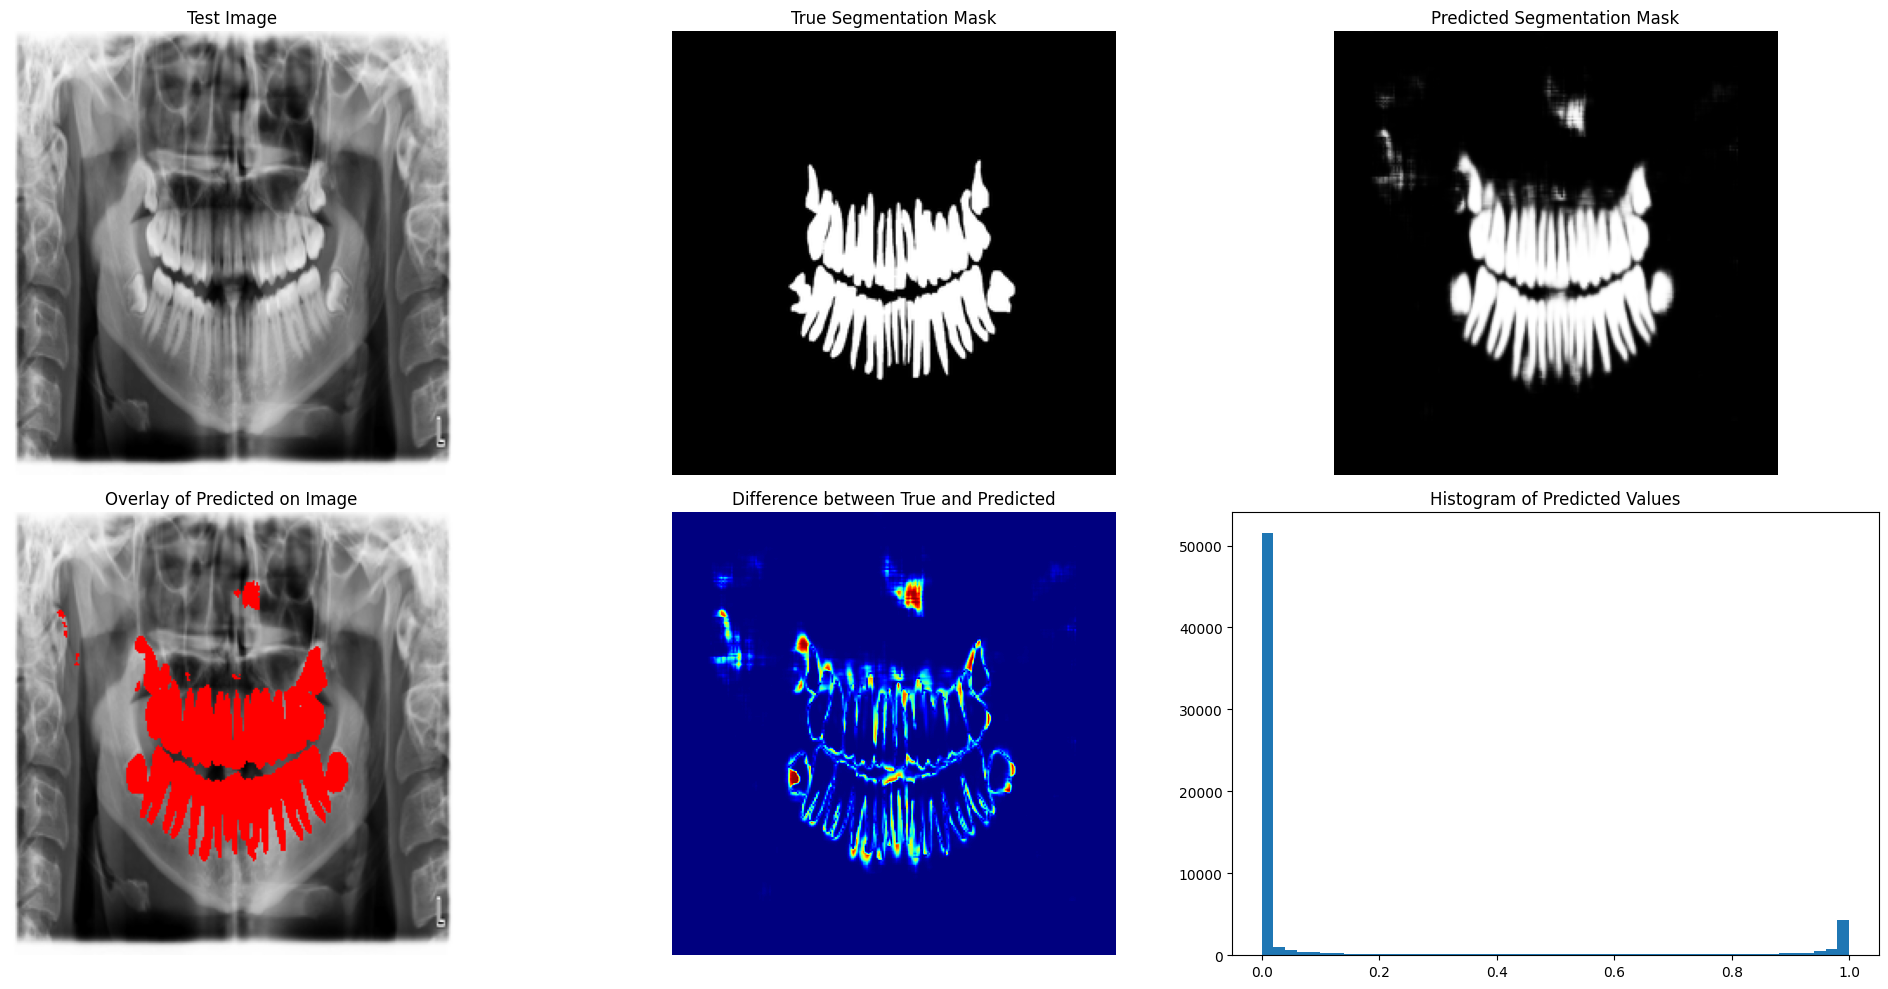

In [ ]:
detailed_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

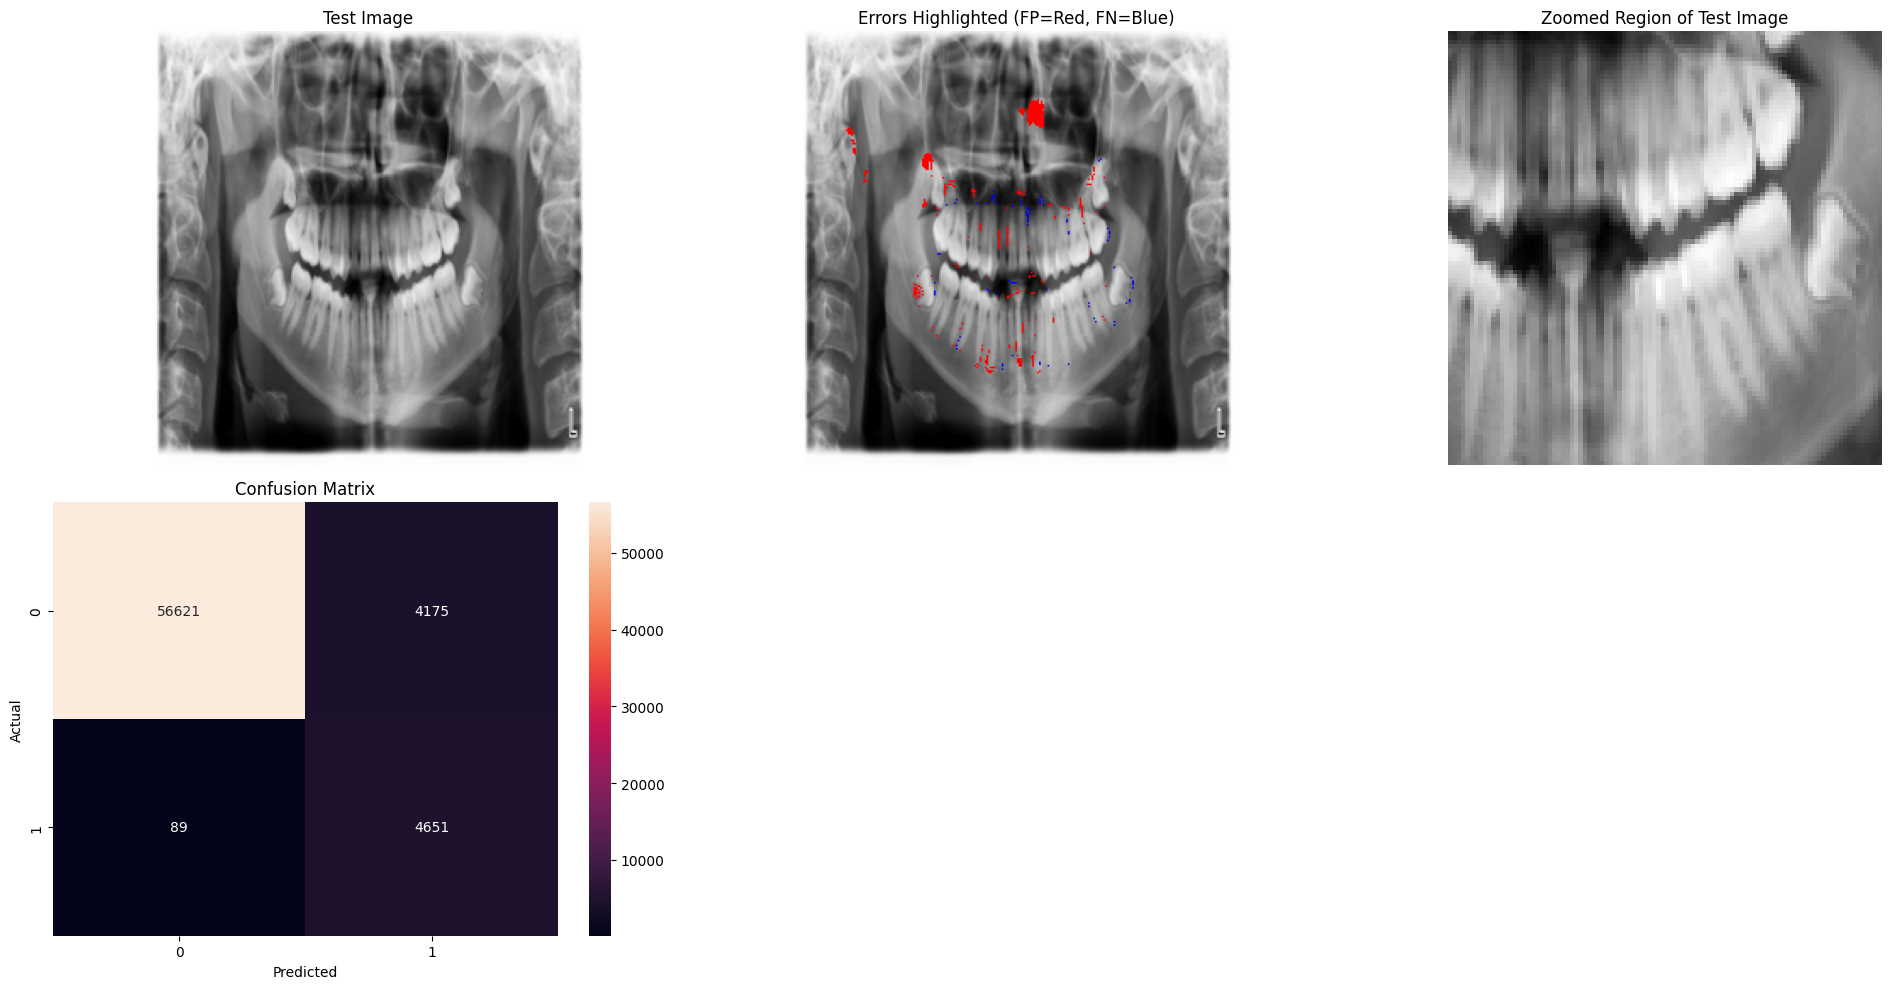

In [ ]:
advanced_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

### **Feedback Attention Unet Model**

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Multiply, Add, Dropout
from keras.layers import ConvLSTM2D, Lambda, Subtract, Reshape
from keras.layers import Conv2DTranspose
from keras.callbacks import EarlyStopping
from keras import backend as K

# Attention gates
def gating_signal(input, out_size, batch_norm=False):
    x = Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same')(phi_g)

    concat_xg = Add()([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = Multiply()([upsample_psi, x])

    result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn

def expend_as(tensor, rep):
   return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)

def attention_feedback_unet(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(32, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(64, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    gating_1 = gating_signal(pool2, 32, True)
    att_1 = attention_block(conv2, gating_1, 32)
    up1 = UpSampling2D(size=(2, 2))(pool2)
    up1 = Conv2D(32, 2, padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    merge1 = Concatenate(axis=3)([att_1, up1])

    convlstm1 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True)(Reshape((1, *merge1.shape[1:]))(merge1))
    convlstm1 = BatchNormalization()(convlstm1)
    convlstm1 = Activation('relu')(convlstm1)
    convlstm1 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same')(convlstm1)
    convlstm1 = BatchNormalization()(convlstm1)
    convlstm1 = Activation('relu')(convlstm1)

    gating_2 = gating_signal(convlstm1, 16, True)
    att_2 = attention_block(conv1, gating_2, 16)
    up2 = UpSampling2D(size=(2, 2))(convlstm1)
    up2 = Conv2D(16, 2, padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    merge2 = Concatenate(axis=3)([att_2, up2])

    convlstm2 = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True)(Reshape((1, *merge2.shape[1:]))(merge2))
    convlstm2 = BatchNormalization()(convlstm2)
    convlstm2 = Activation('relu')(convlstm2)
    convlstm2 = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same')(convlstm2)
    convlstm2 = BatchNormalization()(convlstm2)
    convlstm2 = Activation('relu')(convlstm2)

    output = Conv2D(1, 1, activation='sigmoid')(convlstm2)

    output_prev = output
    convlstm3 = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', return_sequences=True)(Reshape((1, *output_prev.shape[1:]))(output_prev))
    convlstm3 = BatchNormalization()(convlstm3)
    convlstm3 = Activation('relu')(convlstm3)
    convlstm3 = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same')(convlstm3)
    convlstm3 = BatchNormalization()(convlstm3)
    convlstm3 = Activation('relu')(convlstm3)
    output = Subtract()([output_prev, convlstm3])

    model = Model(inputs=inputs, outputs=output)
    return model

input_shape = (256, 256, 1)
funet_model = attention_feedback_unet(input_shape)
funet_model.summary()

funet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

funet_model.fit(x_train, y_train, batch_size=4, epochs=50, verbose=1)

tf.keras.models.save_model(funet_model, '/content/drive/MyDrive/dissertation/dental_xray_seg_attention_new_data_1000_images.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

### **Save Model**

In [ ]:
import tensorflow as tf
tf.keras.models.save_model(funet_model, '/content/drive/MyDrive/dissertation/models/dental_xray_seg_funet_v3_new_data_1000_images_convlstm1_attention.h5')

### **Load the model if already on Drive**

In [ ]:
from tensorflow import keras
import tensorflow.keras.backend as K
funet_model = keras.models.load_model('/content/drive/MyDrive/dissertation/models/dental_xray_seg_funet_v3_new_data_1000_images_convlstm1_attention.h5')

### **Feedback Attention Unet Model Prediction**



In [ ]:
predict_img_funet_v2=funet_model.predict(x_test)
predict=predict_img_funet_v2[1,:,:,0]

7/7 [==============================] - 8s 565ms/step


### **F1-Score**

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
predict_img1_funet_v2=(predict_img_funet_v2>0.25)*1
y_test1=(y_test>0.25)*1
f1_score(predict_img1_funet_v2.flatten(), y_test1.flatten(), average='micro')

0.9614149475097656

### **Dice Score**

In [ ]:
dice_score = (2 * np.sum(predict_img1_funet_v2 * y_test1)) / (np.sum(predict_img1_funet_v2) + np.sum(y_test1))
print("Dice Score:", dice_score)

Dice Score: 0.8632504377677576


### **Precison, Recall, Jaccard Score, IoU**

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, jaccard_score

y_test_flat = y_test1.flatten()
predict_flat = predict_img1_funet_v2.flatten()

threshold = 0.5
predict_binary = np.where(predict_flat > threshold, 1, 0)

precision = precision_score(y_test_flat, predict_binary)
recall = recall_score(y_test_flat, predict_binary)
jaccard_coefficient = jaccard_score(y_test_flat, predict_binary)

intersection = np.sum(y_test_flat & predict_binary)
union = np.sum(y_test_flat | predict_binary)
iou = intersection / union

print("Precision:", precision)
print("Recall:", recall)
print("Jaccard Coefficient (IoU):", jaccard_coefficient)
print("IoU:", iou)

Precision: 0.7891159859111413
Recall: 0.9527584809419416
Jaccard Coefficient (IoU): 0.7594024809409974
IoU: 0.7594024809409974


### **Visualizing the Results of Feedback Attention Unet Model**

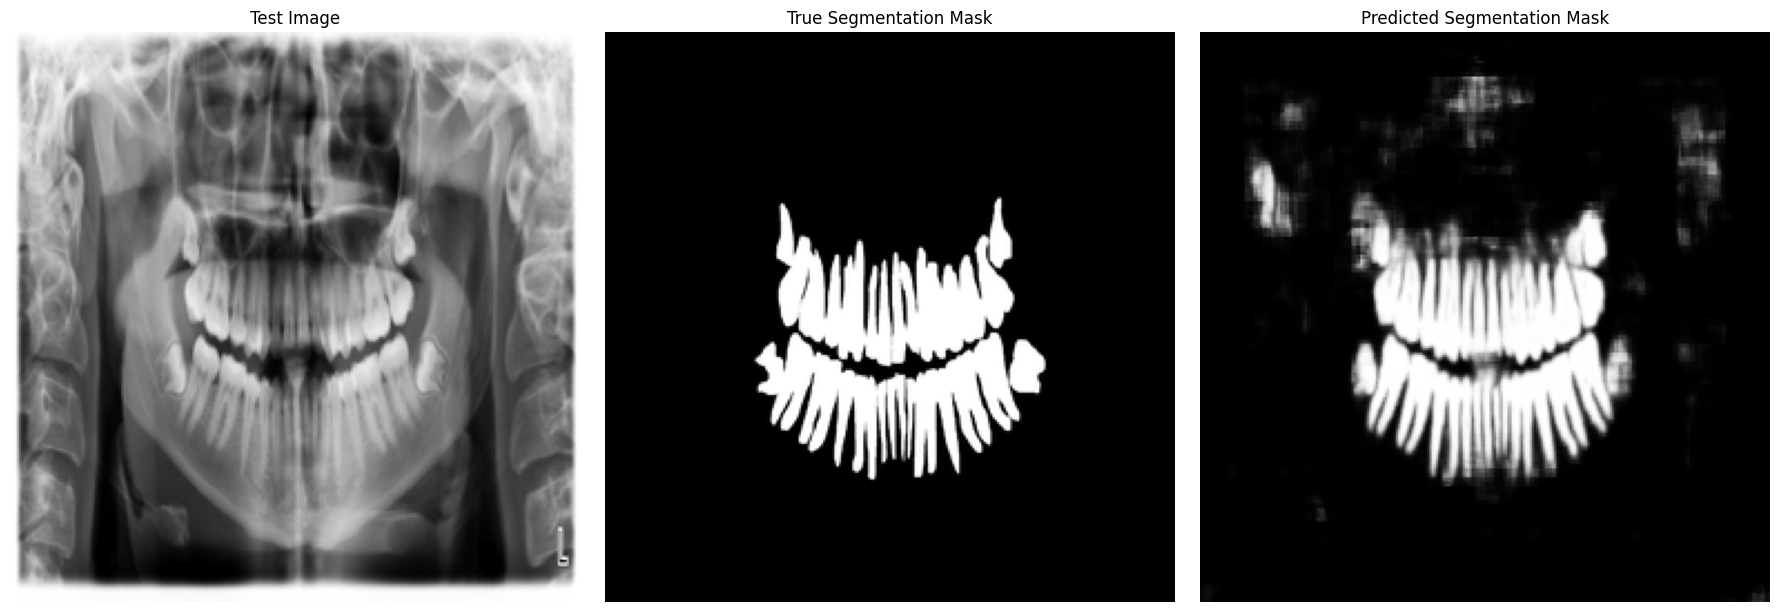

In [ ]:
visualize_prediction(x_test[1,:,:,0], y_test[1,:,:,0], predict)

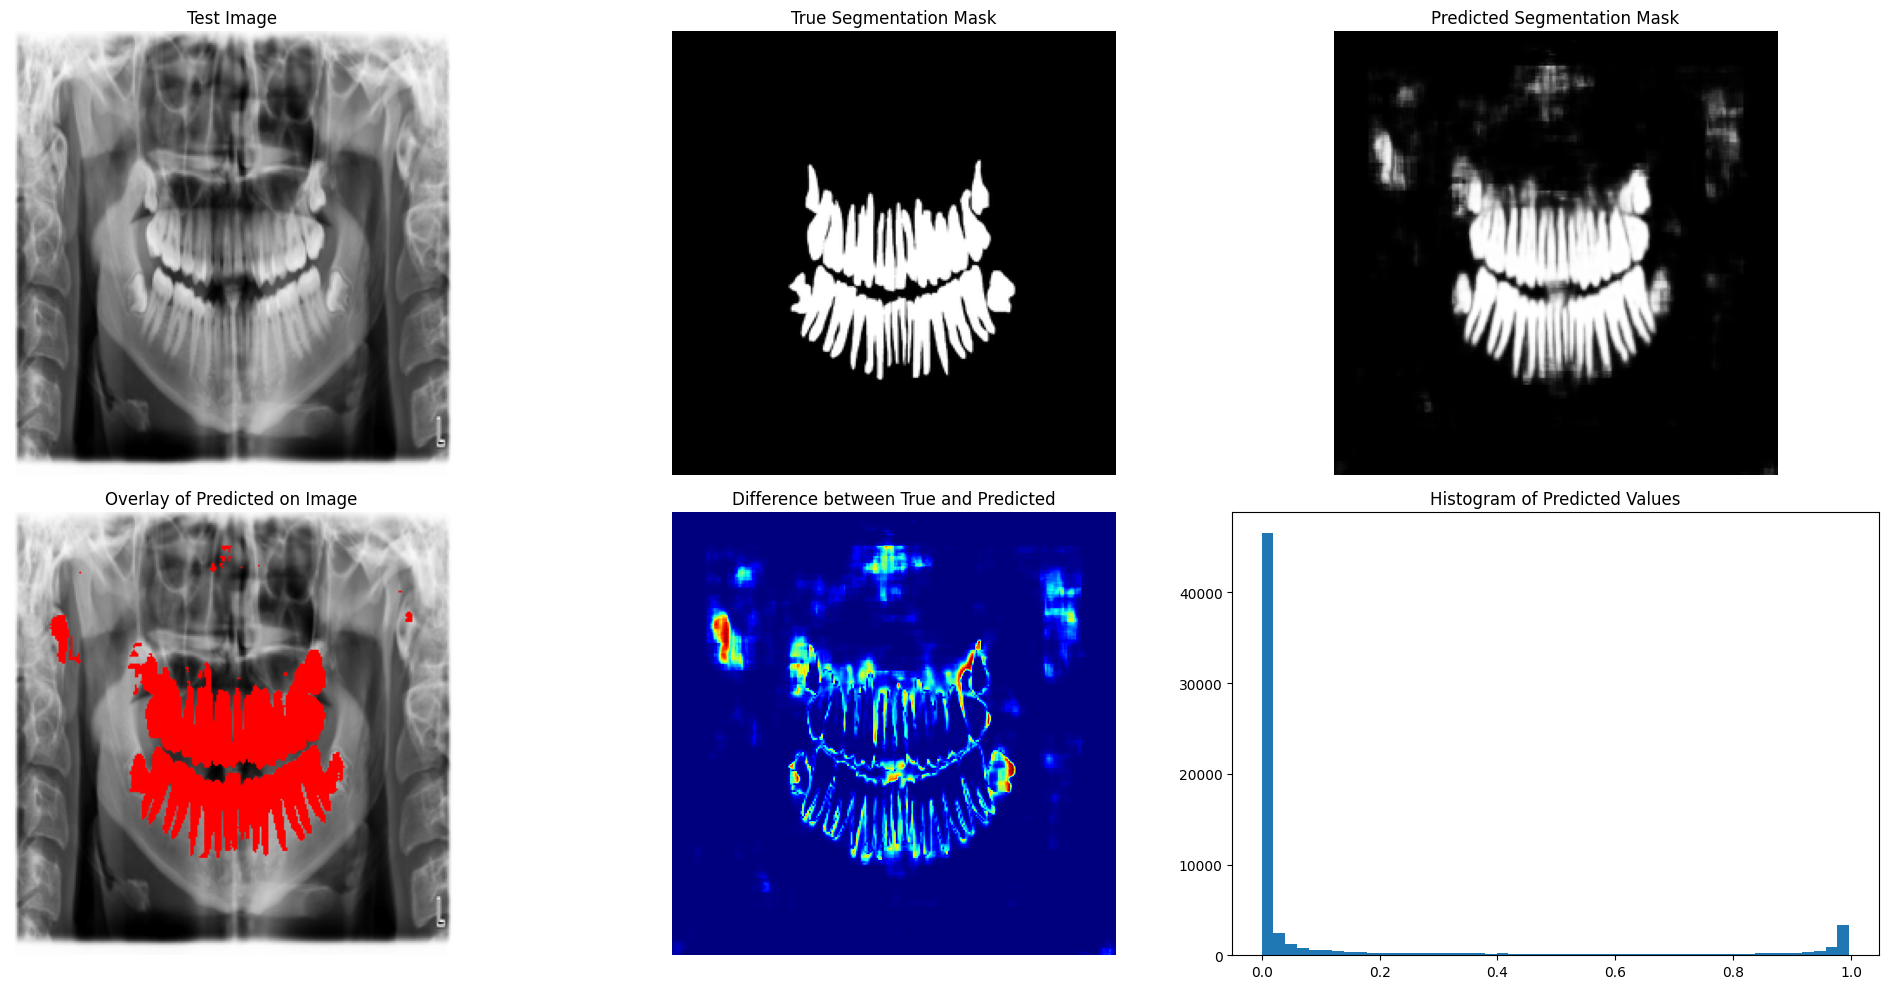

In [ ]:
detailed_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

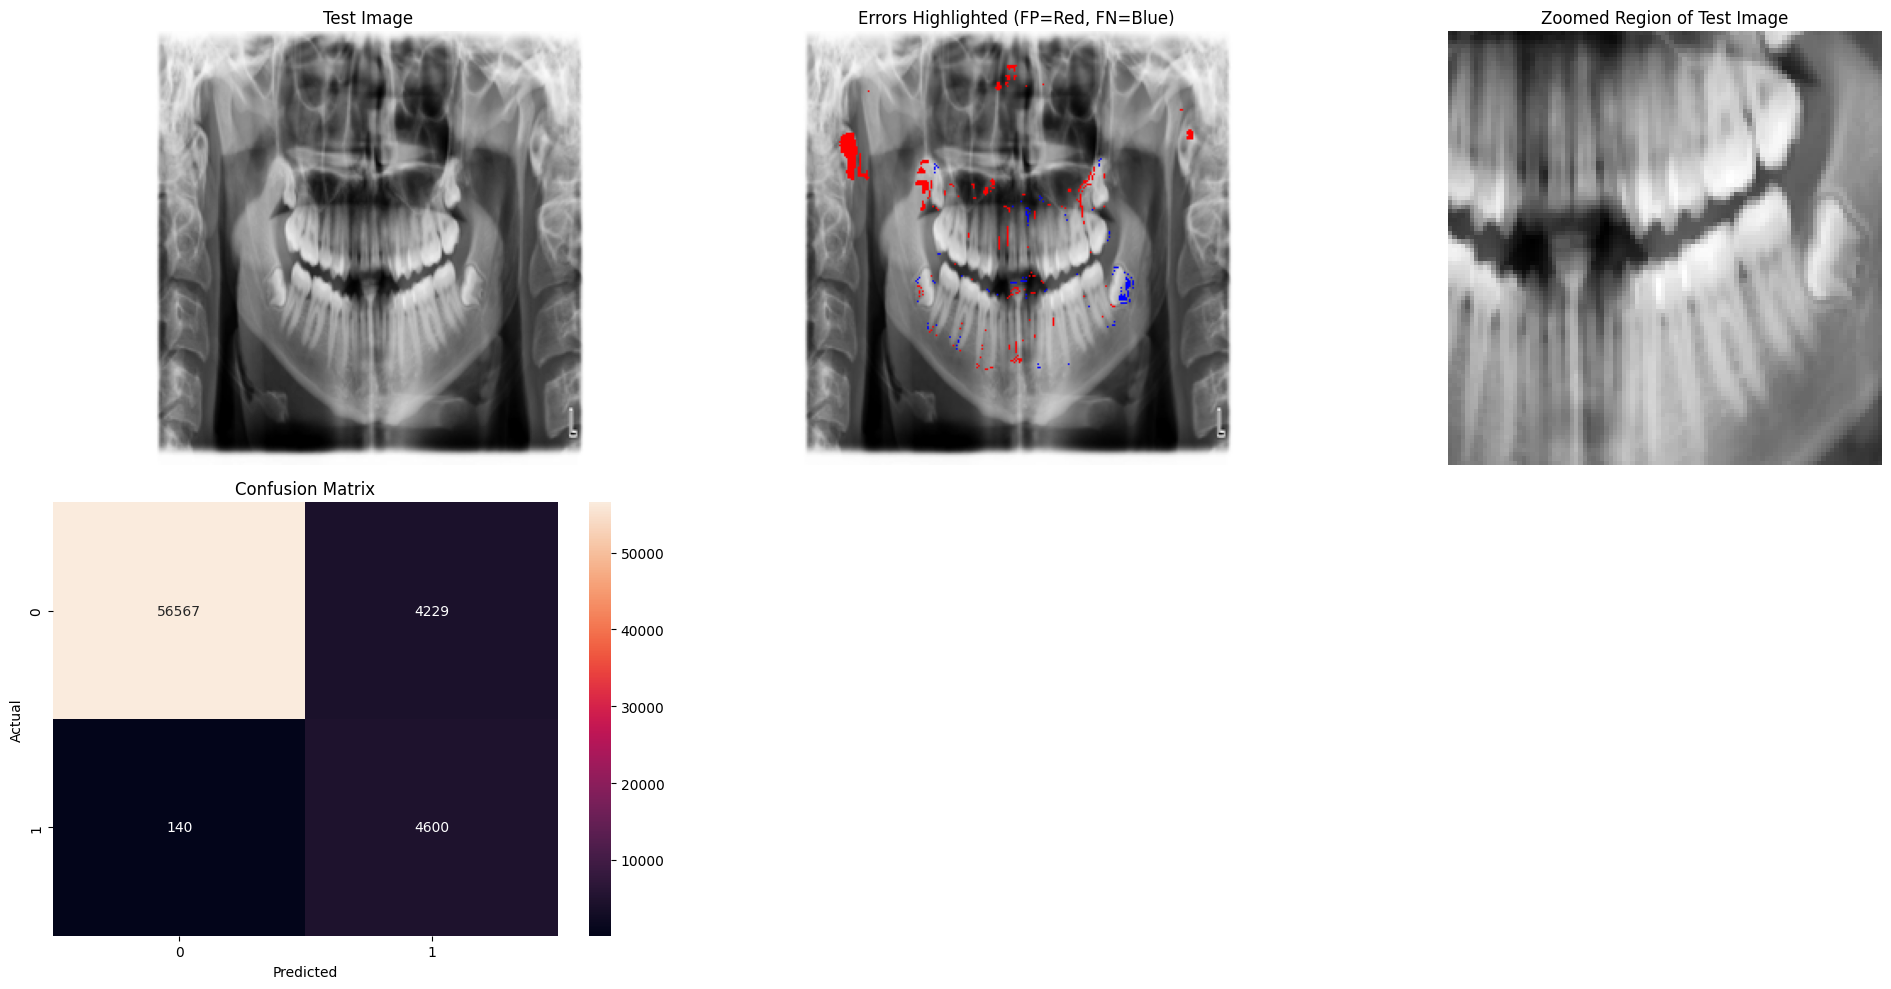

In [ ]:
advanced_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

## **Run below Code after Training or Loading each of the above Models**

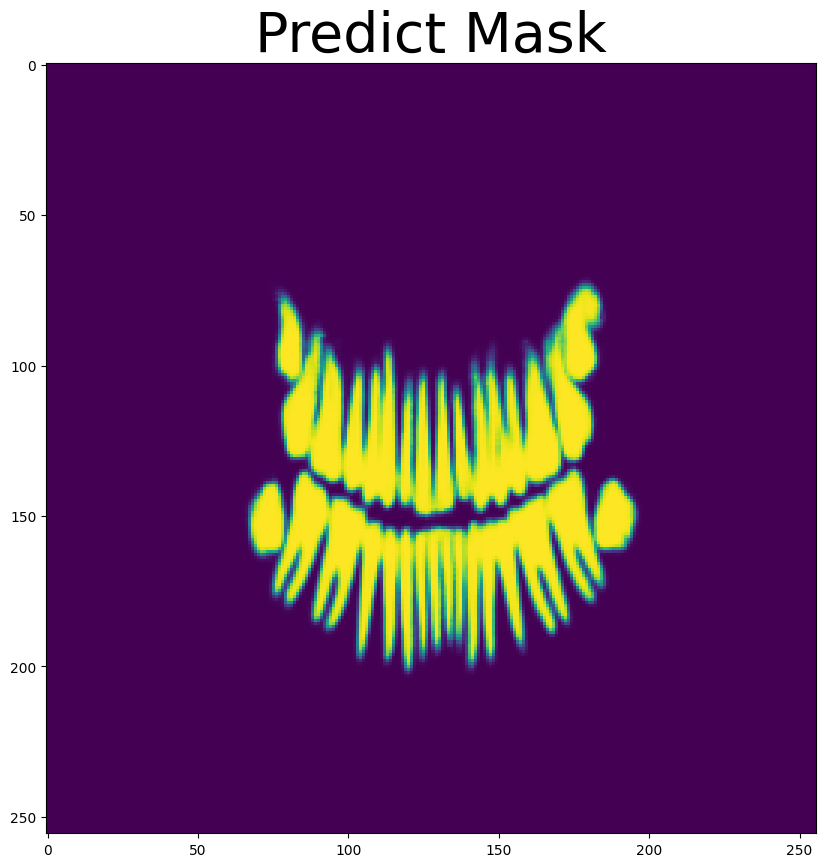

In [ ]:
plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict)
#For CCA, we saved
plt.imsave("/content/drive/MyDrive/dissertation/Resutls_Images/predict_256x256.png",predict)

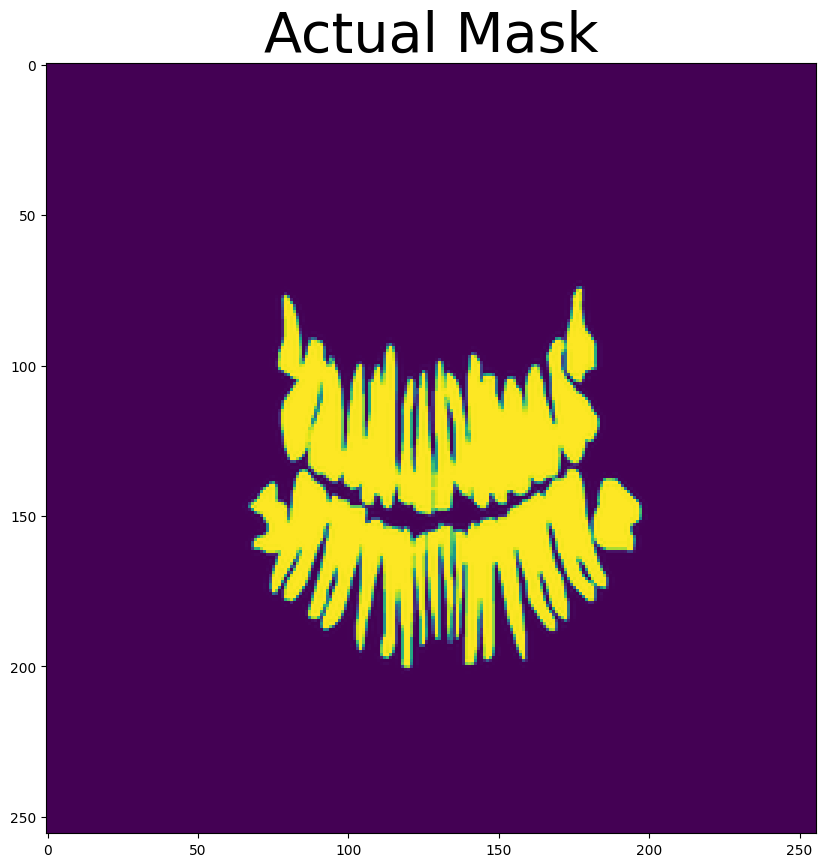

In [ ]:
# Assuming the ground truth masks are stored in y_test
ground_truth = y_test[1,:,:,0]

plt.figure(figsize = (20,10))
plt.title("Actual Mask",fontsize = 40)
plt.imshow(ground_truth)
# Save the actual mask
plt.imsave("/content/drive/MyDrive/dissertation/Resutls_Images/actual_256x256.png",ground_truth)

## **Drawing Contours**

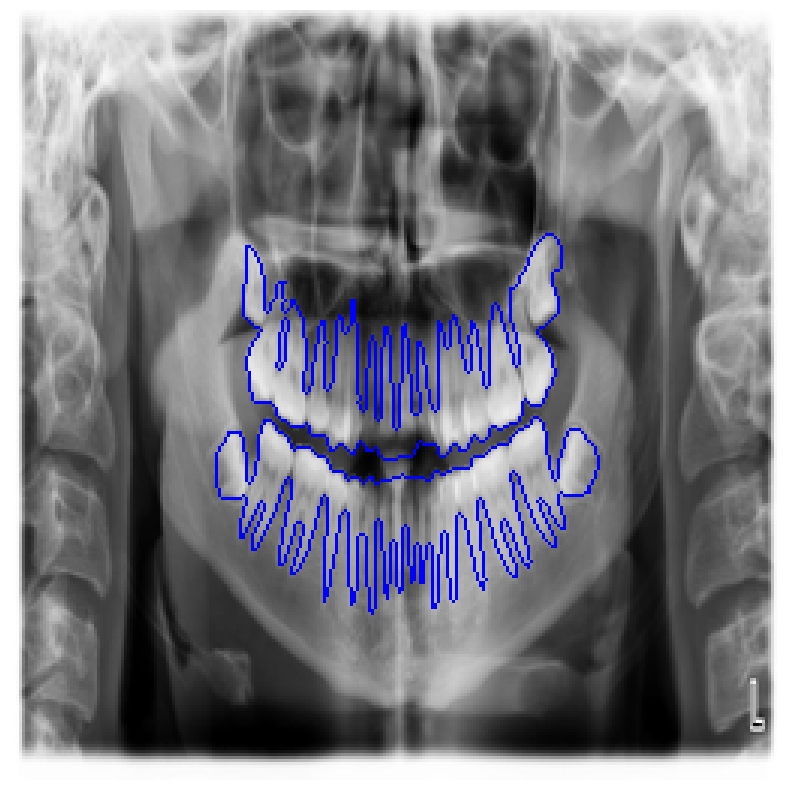

In [ ]:
import cv2
import matplotlib.pyplot as plt
from CCA_Analysis import *

# Load the original image
img = x_test[1]

# Convert the format and values if necessary
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # convert to BGR if necessary
img = np.uint8(img * 255)  # convert to 0-255 if necessary

plt.imsave('/content/drive/MyDrive/dissertation/Resutls_Images/image_test_256x256.png', img, cmap='gray')

# Resize the prediction to match the original image size
predict1 = cv2.resize(predict, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# Convert prediction to a binary mask
mask = np.uint8(predict1 * 255)
_, mask = cv2.threshold(mask, thresh=255/2, maxval=255, type=cv2.THRESH_BINARY)

# Find contours in the mask
cnts, hieararch = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw contours on
img_with_contours = img.copy()

# Draw contours on the copied image
img_with_contours = cv2.drawContours(img_with_contours, cnts, -1, (255, 0, 0), 1)

# Display the modified image with contours using matplotlib
plt.figure(figsize=(10, 10))  # Set the figure size here
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.axis('off')
plt.show()

## **Applying WaterShed Method for Counting of Teeths**

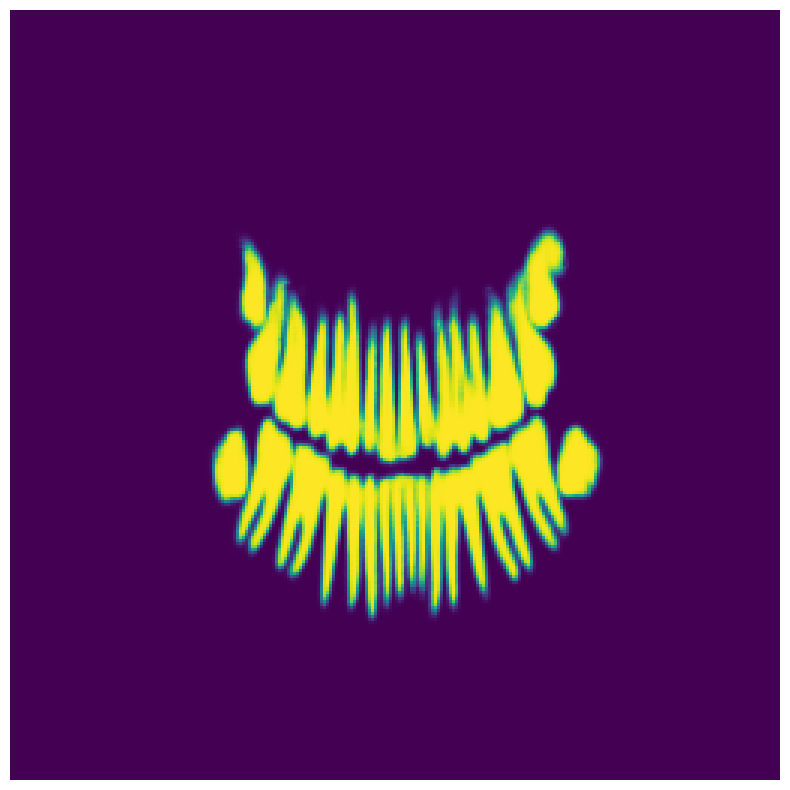

Teeth count: 23


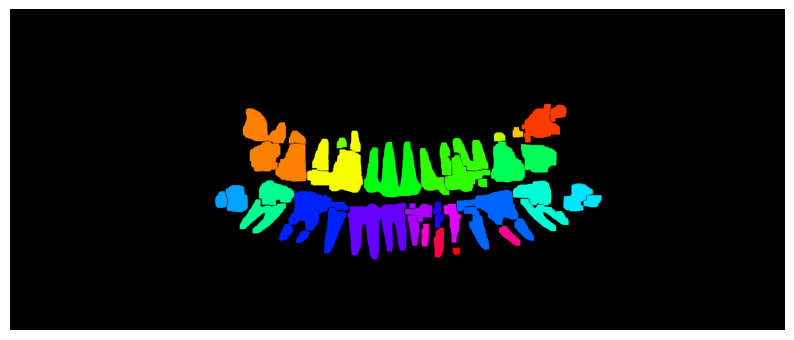

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def filter_by_area(bin_img, min_area):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bin_img)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_area:
            labels[labels == i] = 0

    filtered_img = np.where(labels > 0, 255, 0).astype('uint8')
    return filtered_img

def CCA_Analysis(base_image, mask, erode_iteration=0, open_iteration=8):
    kernel = np.ones((3,3), np.uint8)

    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, bin_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)

    if erode_iteration > 0:
        eroded_mask = cv2.erode(bin_mask, kernel, iterations=erode_iteration)
    else:
        eroded_mask = bin_mask

    opened_mask = cv2.morphologyEx(eroded_mask, cv2.MORPH_OPEN, kernel, iterations=open_iteration)
    opened_mask = filter_by_area(opened_mask, min_area=500)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(opened_mask)

    for i in range(1, num_labels):
        x, y, w, h = stats[i][:4]
        cv2.rectangle(base_image, (x,y), (x+w,y+h), (0,255,0), 2)  # Green bounding box

    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue==0] = 0

    return labeled_img, num_labels - 1


# Load the images
img_colored = cv2.imread("/content/drive/MyDrive/dissertation/Resutls_Images/image_test_256x256.png")
predicted = cv2.imread("/content/drive/MyDrive/dissertation/Resutls_Images/predict_256x256.png")

# Preprocessing steps
img_colored = cv2.resize(img_colored, (2780, 1150), interpolation=cv2.INTER_LANCZOS4)

# Keep a grayscale version for other operations
img = cv2.cvtColor(img_colored, cv2.COLOR_BGR2GRAY)
img = cv2.equalizeHist(img)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

predicted = cv2.resize(predicted, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# Convert predicted to grayscale
gray_predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2GRAY)

# Convert grayscale mask to binary using Otsu's thresholding
_, bin_mask = cv2.threshold(gray_predicted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Watershed algorithm
dist_transform = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(bin_mask, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
cv2.watershed(img_colored, markers)
predicted[markers == -1] = [0, 0, 255]  # Boundary region

cca_result, teeth_count = CCA_Analysis(img, predicted)
print('Teeth count:', teeth_count)

# Display the results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(cca_result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Teeth Count: 27


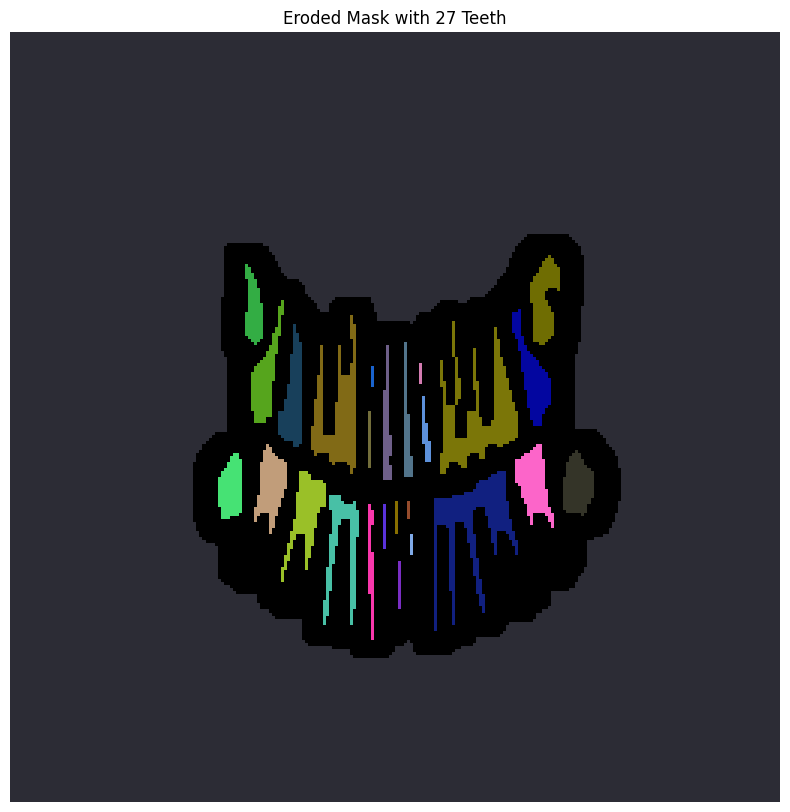

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adaptive_threshold_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

def erode_mask(mask, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.erode(mask, kernel, iterations=iterations)

def count_objects_in_mask(mask):
    _, output = cv2.connectedComponents(mask)
    return output.max()  # Returns the number of unique components (minus 1 for the background)

def remove_thin_lines(mask, kernel_size, iterations=2):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_size))

    cleaned_mask = np.copy(mask)
    for i in range(iterations):
        # Erode with the kernel
        lines = cv2.erode(cleaned_mask, kernel, iterations=1)
        lines = cv2.dilate(lines, kernel, iterations=1)

        # Subtract the eroded mask from the original mask to highlight the lines
        highlighted_lines = cv2.subtract(cleaned_mask, lines)

        # Remove the highlighted lines from the mask
        cleaned_mask = cv2.subtract(cleaned_mask, highlighted_lines)

    return cleaned_mask

def color_components(mask):
    # Get connected components
    num_labels, labels = cv2.connectedComponents(mask)

    # Map each label to a random RGB color
    colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=int)
    colors[0] = [0, 0, 0]  # Set background color to black

    # Create a color image
    color_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(1, num_labels):  # Skip the background
        color_img[labels == i] = colors[i]

    return color_img

# Load the predicted mask
predicted = cv2.imread("/content/drive/MyDrive/dissertation/Resutls_Images/predict_256x256.png")
enhanced_mask = adaptive_threshold_mask(predicted)

# Erode the mask to create more separation
eroded_mask = erode_mask(enhanced_mask, kernel_size=3, iterations=1)

cleaned_mask = remove_thin_lines(eroded_mask, kernel_size=5, iterations=2)

# Counting teeth in the cleaned mask
teeth_count = count_objects_in_mask(cleaned_mask)
print(f"Teeth Count: {teeth_count}")

# Color each tooth
colored_image = color_components(cleaned_mask)

plt.figure(figsize=(10, 10))
plt.imshow(colored_image)
plt.axis('off')
plt.title(f'Eroded Mask with {teeth_count} Teeth')
plt.show()